## Load data

In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
import platform
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import time
import math

In [3]:
print("python version:\t\t", platform.python_version())
print("networkx version:\t", nx.__version__)

python version:		 3.8.3
networkx version:	 2.4


In [4]:
def load_pickle(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)     
G2 = load_pickle('Subgraph5.pkl')
print(nx.info(G2))

Name: 
Type: MultiDiGraph
Number of nodes: 12370866
Number of edges: 64827148
Average in degree:   5.2403
Average out degree:   5.2403


In [5]:
# Travelsal edges:
for ind, edge in enumerate(nx.edges(G2)):
    # gets the nodes on both sides of the edge.
    (u, v) = edge
    # gets the first edge from node u to node v.
    eg = G2[u][v][0]
    # gets the properties of the directed edge: the amount and timestamp of the transaction.
    amo, tim = eg['amount'], eg['timestamp']
    print("amount:", amo)
    print("timestamp:", tim)
    break

amount: 0.311237
timestamp: 1593532806


## Statistics

In [6]:
def shift_time(timeStamp):
    timeArray=time.localtime(timeStamp)
    otherStyleTime=time.strftime("%Y--%m--%d %H:%M:%S",timeArray)
#     year=timeArray.tm_year
#     month=timeArray.tm_mon
#     day=timeArray.tm_mday
    return otherStyleTime

In [7]:
phishing_set=set(pd.read_csv('addresses/Phish.csv')['Phish'].values.tolist())

In [8]:
all_ndset=set([nd for idx,nd in enumerate(G2.nodes)])
phishing_set=phishing_set&all_ndset
print(len(phishing_set))

505


In [9]:
phish_in_neighs=[len(G2.pred[nd]) for nd in phishing_set]
phish_out_neighs=[len(G2.succ[nd]) for nd in phishing_set]
phish_acum_ratio=[len(G2.pred[nd])/(len(G2.pred[nd])+len(G2.succ[nd])) for nd in phishing_set]

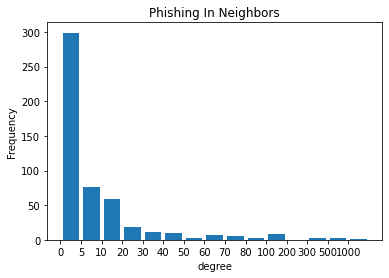

In [10]:
#plt indegree
bins=[0,5,10,20,30,40,50,60,70,80,100,200,300,500,1000,10000]
hist,bin_edges = np.histogram(phish_in_neighs,bins) # make the histogram
plt.title('Phishing In Neighbors')
plt.ylabel('Frequency')
plt.xlabel('degree')

# # Plot the histogram heights against integers on the x axis
plt.bar(range(len(hist)),hist,width=0.8) 

# # Set the ticks to the middle of the bars
plt.xticks([i-0.5 for i,j in enumerate(hist)],['{}'.format(bins[i]) for i,j in enumerate(hist)])
                                                           
plt.show()
# plt.hist(phish_indegree,bins)

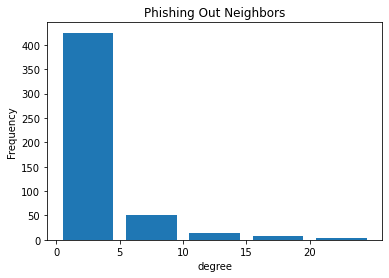

In [11]:
#plt outdegree
bins=list(range(0,30,5))
hist,bin_edges = np.histogram(phish_out_neighs,bins) # make the histogram
plt.title('Phishing Out Neighbors')
plt.ylabel('Frequency')
plt.xlabel('degree')

# # Plot the histogram heights against integers on the x axis
plt.bar(range(len(hist)),hist,width=0.8) 

# # Set the ticks to the middle of the bars
plt.xticks([i-0.5 for i,j in enumerate(hist)],['{}'.format(bins[i]) for i,j in enumerate(hist)])
                                                           
plt.show()
# plt.hist(phish_indegree,bins)

(array([ 36.,   6.,  13.,  22.,  17., 127.,  50.,  38.,  54., 142.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

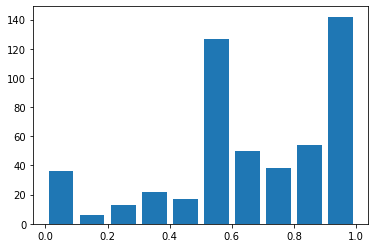

In [12]:
plt.hist(phish_acum_ratio,10,(0,1),rwidth=0.8)

In [13]:
np.mean(phish_acum_ratio)

0.6559272720650984

## Service Address Classification

In [14]:
exchange_set=set(pd.read_csv('addresses/Exchange.csv')['Exchange'].values.tolist())

In [15]:
dex_set=set(pd.read_csv('addresses/DEX.csv')['DEX'].values.tolist())

In [16]:
exchange_set=exchange_set&all_ndset
dex_set=dex_set&all_ndset
print(len(exchange_set),len(dex_set))

197 768


In [17]:
all_exchanges=exchange_set|dex_set
print(len(all_exchanges))

965


In [18]:
token_set=set(pd.read_csv('addresses/Token.csv')['Token'].values.tolist())

In [19]:
token_set=token_set&all_ndset
print(len(token_set))

132


In [20]:
phishing_token=token_set&phishing_set
print(len(phishing_token))
token_set=token_set-phishing_token
print(len(token_set))

0
132


In [21]:
contract_set=set(pd.read_csv('addresses/Contract.csv')['Smart Contract'].values.tolist())&all_ndset
print(len(contract_set))

390667


In [22]:
print(contract_set&phishing_set)

{'0x4fd942e51d15cdb966b58c3297d6d7e24d27480b', '0x48ca1b283148a9c90bb443c45360f1dd19b47f12', '0x11343194b9ba84c8e5629ffec4f604f410ed28fc', '0x8ab2a5c943d71959e73dcd7c075947c27d63cffd', '0xeb17037df15f171163d82c586c5b65ef112924ca', '0x514efa2ecc1be6228e46f45999dee7f1e9ed7b9a', '0x13d0f60b2aaaccbab97551219b16bc41dac84c5a', '0xe32da8605e6d4802f9fa9a5e3776c12e06cb93f1', '0x8e22c4713896cf2b69a0cc1b206c8fad980db322', '0x6032d639e634e788fce323b316e06d18194f99a8'}


In [23]:
inactive_set=set(pd.read_csv('addresses/EOA_inactive.csv')['EOA/inactive'].values.tolist())&all_ndset
print(len(inactive_set))

3520886


In [24]:
print(len(inactive_set&phishing_set))

55


In [25]:
hack_set=set(pd.read_csv('addresses/Hack.csv')['Hack'].values.tolist())
hack_set=hack_set&all_ndset
print(len(hack_set))

5


In [26]:
def set_bool_label(labelname,label_set):
    for idx,nd in enumerate(G2.nodes):
        G2.nodes[nd][labelname]=0
    for nd in label_set:
        G2.nodes[nd][labelname]=1

In [27]:
set_bool_label('isp',phishing_set)
set_bool_label('ish',hack_set)

In [28]:
set_bool_label('iss',all_exchanges)
set_bool_label('ist',token_set)

In [29]:
set_bool_label('isc',contract_set)
set_bool_label('is_inact',inactive_set)

## Degree  distribution

In [30]:
n=len(G2.nodes)
in_degrees=dict()
out_degrees=dict()

#compute in-degree and out-degree of all nodes

#in-degree
for idx,indegree in enumerate(G2.in_degree()):
    (nd,idg)=indegree
    in_degrees[nd]=idg
in_values=sorted(set(in_degrees.values()))
in_hist=[list(in_degrees.values()).count(x) for x in in_values]
print(len(in_values),len(in_hist))
in_distrb=[x/n for x in in_hist]

#out-degree
for idx,outdegree in enumerate(G2.out_degree()):
    (nd,odg)=outdegree
    out_degrees[nd]=odg
out_values=sorted(set(out_degrees.values()))
out_hist=[list(out_degrees.values()).count(x) for x in out_values]
out_distrb=[x/n for x in out_hist]
print(len(out_values),len(out_hist))

2327 2327
2668 2668


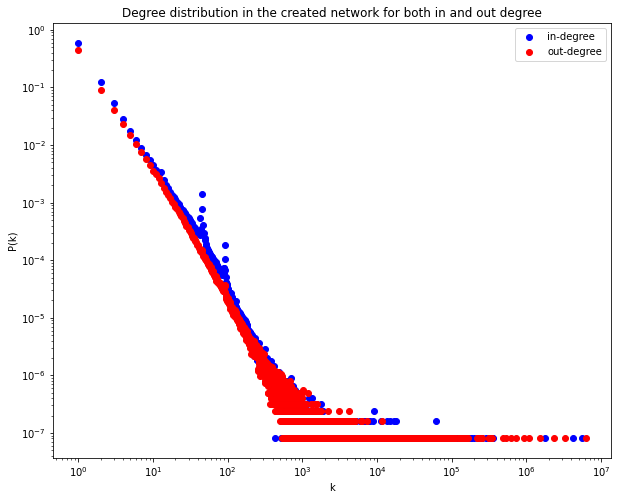

In [31]:
#plot the degree distribution
xlabel="k"
ylabel="P(k)"
title="Degree distribution in the created network for both in and out degree"
figsize=(10,8)
plt.figure(figsize=figsize)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(title)
plt.loglog(in_values,in_distrb,'o',color='blue',label='in-degree')
plt.loglog(out_values,out_distrb,'o',color='red',label='out-degree')
plt.legend(loc='upper right')
plt.show()

In [32]:
#top addresses with the higheset node degree
L_in=sorted(in_degrees.items(),key=lambda x:x[1],reverse=True)
print(L_in[:5])
L_out=sorted(out_degrees.items(),key=lambda x:x[1],reverse=True)
print(L_out[:5])

[('0x7a250d5630b4cf539739df2c5dacb4c659f2488d', 5539680), ('0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', 4228274), ('0x5acc84a3e955bdd76467d3348077d003f00ffb97', 1768135), ('0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be', 358092), ('0xa090e606e30bd747d4e6245a1517ebe430f0057e', 348796)]
[('0x7a250d5630b4cf539739df2c5dacb4c659f2488d', 6187713), ('0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', 3273870), ('0x5acc84a3e955bdd76467d3348077d003f00ffb97', 2308335), ('0xea674fdde714fd979de3edf0f56aa9716b898ec8', 1522490), ('0xdb25ff2868cbc48856e44a2ae8e2f2b62f1f3b84', 1088750)]


In [33]:
N_in=sorted([len(G2.pred[nd]) for idx,nd in enumerate(G2.nodes)])
N_out=sorted([len(G2.succ[nd]) for idx,nd in enumerate(G2.nodes)])

In [34]:
print(N_in[int(len(G2)*0.999):int(len(G2)*0.999)+5])
print(N_out[int(len(G2)*0.999):int(len(G2)*0.999)+5])

[34, 34, 34, 34, 34]
[48, 48, 48, 48, 48]


##  Detect Phishing Gang (with taint analysis)

In [35]:
#link weight and node value method
#compute sum of in-links and out-links
for idx,nd in enumerate(G2.nodes):
    G2.nodes[nd]['out_values']=0
    for ond,label in G2.adj[nd].items():
        amounts=[x['amount'] for x in label.values()]#sum of transaction amount of two nodes 
        G2.nodes[nd]['out_values']+=sum(amounts)
    G2.nodes[nd]['in_values']=0
    for ind,label in G2.pred[nd].items():
        amounts=[x['amount'] for x in label.values()]
        G2.nodes[nd]['in_values']+=sum(amounts)
print(G2.nodes[nd]['in_values'],G2.nodes[nd]['out_values'])

0.009 0


In [36]:
#initial label of nodes
def initial_taint(original_nodes):
    for idx,nd in enumerate(G2.nodes):
        if nd in original_nodes:
            G2.nodes[nd]['taint']=1
            G2.nodes[nd]['visited']=True
        else:
            G2.nodes[nd]['taint']=0
            G2.nodes[nd]['visited']=False
        
#link weight and node value equation            
def taint_compute1(node):
    taint_sum=0
    for ind,label in G2.pred[node].items():
        amounts=[int(x['amount']) for x in label.values()]
        taint_sum+=G2.nodes[ind]['taint']*sum(amounts)
    return taint_sum/G2.nodes[node]['in_values'] if G2.nodes[node]['in_values']>0 else 0
        
#BFS spread
def taint_spread1(original_nodes):
    #initial
    initial_taint(original_nodes)
    #spread
    queue=original_nodes.copy()
    while len(queue)>0:
        pre_nd=queue.pop(0)
        for nd in G2.adj[pre_nd]:
            if not G2.nodes[nd]['visited'] and G2.nodes[nd]['iss']!=1 and G2.nodes[nd]['ist']!=1:
                G2.nodes[nd]['visited']=True
                queue.append(nd)
                G2.nodes[nd]['taint']=taint_compute1(nd)

In [37]:
taint_spread1(list(phishing_set))
in_tainted_values1=[G2.nodes[nd]['taint'] for idx,nd in enumerate(G2.nodes)]
in_tainted_values1=sorted(in_tainted_values1,reverse=True)

In [38]:
#link weight and node value equation            
def taint_compute(node,days):
    weight_list=[]
    for ind,label in G2.pred[node].items():
        weight_list.extend([(x['timestamp'],x['amount'],ind) for x in label.values()])
    weight_list=sorted(weight_list,key=lambda x:x[0])
    time_step=days*24*60*60
    time_begin=weight_list[0][0]
    time_end=weight_list[-1][0]
    taint_values=[]
    taint_sum=0
    money_sum=0
    for tim,val,ind in weight_list:
        if time_begin+time_step>tim:
            taint_sum+=G2.nodes[ind]['taint']*val
            money_sum+=val
        else:
            break
    taint_values.append(taint_sum/money_sum if money_sum>0 else 0)
    for i in range(1,len(weight_list)):
        time_begin=weight_list[i][0]
        if time_begin+time_step<time_end:
            break
        else:
            for j in range(i,len(weight_list)):
                tim,val,ind=weight_list[j]
                if time_begin+time_step>tim:
                    taint_sum+=G2.nodes[ind]['taint']*val
                    money_sum+=val
                else:
                    break
            taint_values.append(taint_sum/money_sum if money_sum>0 else 0)
    return max(taint_values)   

#BFS spread
def taint_spread_iter(original_nodes):
    #spread
    queue=original_nodes.copy()
    while len(queue)>0:
        pre_nd=queue.pop(0)
        for nd in G2.adj[pre_nd]:
            if not G2.nodes[nd]['visited'] and G2.nodes[nd]['iss']!=1 and G2.nodes[nd]['ist']!=1:
                G2.nodes[nd]['visited']=True
                queue.append(nd)
                G2.nodes[nd]['taint']=taint_compute(nd,15)

def taint_spread(original_nodes,iter_num):
    initial_taint(original_nodes)
    for i in range(iter_num):
        taint_spread_iter(original_nodes)

In [39]:
#Get the values of link wight ratio TaintRank
taint_spread(list(phishing_set),1)

In [40]:
in_tainted_values=[G2.nodes[nd]['taint'] for idx,nd in enumerate(G2.nodes)]
in_tainted_values=sorted(in_tainted_values,reverse=True)

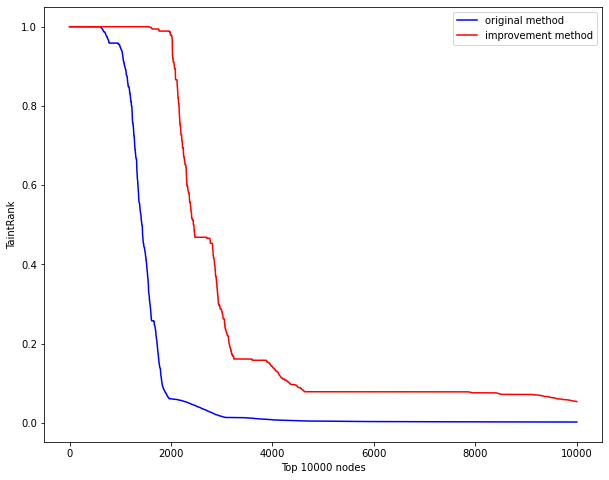

In [41]:
#plot
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 15,
}
xlabel="Top 10000 nodes"
ylabel="TaintRank"
title="Jul~Sep.2020"
figsize=(10,8)
plt.figure(figsize=figsize)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
# plt.title(title,font1)
plt.plot(range(10000),in_tainted_values1[:10000],color='blue',label='original method')
plt.plot(range(10000),in_tainted_values[:10000],color='red',label='improvement method')
plt.legend(loc='upper right')
plt.show()

In [42]:
print(len([val for val in in_tainted_values if val>0]))

4697554


In [43]:
def is_accumulation(nd):
    inn=len(G2.pred[nd])
    outn=len(G2.succ[nd])
    ratio=inn/(inn+outn) if (inn+outn)>0 else 0
    ins=G2.in_degree[nd]
    outs=G2.out_degree[nd]
    iratio=ins/inn if inn>0 else 0
    oratio=outs/outn if outn>0 else 0
    in_values=G2.nodes[nd]['in_values']
    out_values=G2.nodes[nd]['out_values']
    if ratio>=0.7 and inn>10 and inn<230 and outn>0 and outn<66 and iratio<=2 and oratio<=4 and in_values>0 and out_values>0:
        return True
    return False

def is_bridge(nd):
    inn=len(G2.pred[nd])
    outn=len(G2.succ[nd])
    taint=G2.nodes[nd]['taint']
    if inn<=3 and outn<=3 and taint>=0.1:
        return True
    if taint>=0.5:
        return True
    return False

def is_token(nd):
    if G2.nodes[nd]['ist']==1:
        return True
    return False

def is_exchange(nd):
    if G2.nodes[nd]['iss']==1:
        return True
    return False

def is_phish(nd):
    if G2.nodes[nd]['isp']==1:
        return True
    return False

def is_hack(nd):
    if G2.nodes[nd]['ish']==1:
        return True
    return False

for idx,nd in enumerate(G2.nodes):
    if len(G2.pred[nd])+len(G2.succ[nd])>=100:
        G2.nodes[nd]['label']='HC'
    else:
        G2.nodes[nd]['label']='LC'
    if is_accumulation(nd):
        G2.nodes[nd]['label']='A'
    if is_bridge(nd):
        G2.nodes[nd]['label']='B'
    if is_token(nd):
        G2.nodes[nd]['label']='T'
    if is_exchange(nd):
        G2.nodes[nd]['label']='E'
    if is_hack(nd):
        G2.nodes[nd]['label']='H'
    if is_phish(nd):
        G2.nodes[nd]['label']='P'

In [44]:
accum_address=[nd for idx,nd in enumerate(G2.nodes) if is_accumulation(nd)]
accum_phish=[nd for nd in phishing_set if is_accumulation(nd)]
print(len(phishing_set)/len(G2),len(accum_phish)/len(accum_address),len(accum_address),len(accum_phish))

4.082171773584808e-05 0.00559422363884733 15373 86


In [45]:
def initial_visit(original_nd):
    G2.nodes[original_nd]['visited']=True
    for idx,nd in enumerate(G2.nodes):
        if nd!=original_nd:
            G2.nodes[nd]['visited']=False
            
def detection_phishing_gang2(phishing_nd):
    initial_visit(phishing_nd)
    phishing_gang=set()
    mates=set()
    acc_set=set()
    mates.add(phishing_nd)
    while len(mates)!=0:
        b=mates.pop()
        G2.nodes[b]['visited']=True
        bri_set=set()
        psh_set=set()
        hac_set=set()
        for nd in G2.pred[b]:
            if not G2.nodes[nd]['visited']:
                if G2.nodes[nd]['label']=='A':
                    acc_set.add(nd)
                if G2.nodes[nd]['label']=='B':
                    bri_set.add(nd)
                if G2.nodes[nd]['label']=='P':
                    psh_set.add(nd)
                if G2.nodes[nd]['label']=='H':
                    hac_set.add(nd)
        for nd in G2.succ[b]:
            if not G2.nodes[nd]['visited']:
                if G2.nodes[nd]['label']=='A':
                    acc_set.add(nd)
                if G2.nodes[nd]['label']=='B':
                    bri_set.add(nd)
                if G2.nodes[nd]['label']=='P':
                    psh_set.add(nd)
                if G2.nodes[nd]['label']=='H':
                    hac_set.add(nd)
        phishing_gang.add(b)
        mates=mates|bri_set|psh_set|hac_set
    #select suspect phishing    
    for nd in acc_set:
        in_gang_values=0
        out_gang_values=0
        for pnd,label in G2.pred[nd].items():
            if pnd in phishing_gang:
                in_gang_values+=sum([x['amount'] for x in label.values()])
        for snd,label in G2.succ[nd].items():
            if snd in phishing_gang:
                out_gang_values+=sum([x['amount'] for x in label.values()])
        if out_gang_values/G2.nodes[nd]['out_values']>=0.1 or in_gang_values/G2.nodes[nd]['in_values']>=0.1:
            phishing_gang.add(nd)
    return phishing_gang.copy()

In [46]:
phishing_gang_sets2=[]
for ond in phishing_set:
    phishing_gang=detection_phishing_gang2(ond)
    phishing_gang_sets2.append(phishing_gang)
    print(len(phishing_gang),end=' ')

72 1 56 2 69 1 6 2 56 1 1 27 6 1 2 1 25 2 2 7 2 1 2 2 1 1 4 5 1 3 5 1 4 1 6 5 7 1 5 11 3 7 1 1 26 6 69 2 13 2 2 9 3 57 1 69 7 3 2 1 2 9 29 1 2 11 55 1 3 23 4 24 1 1 2 23 5 5 1 1 4 5 1 11 7 25 7 3 1 11 1 5 2 1 2 25 35 2 4 1 7 3 1 1 4 4 3 88 1 34 4 3 88 2 2 23 1 6 9 4 1 25 14 3 23 2 10 1 5 2 9 1 69 62 5 6 1 1 3 29 1 8 45 1 24 9 23 1 3 9 1 1 2 1 69 7 12 1 30 5 4 1 88 88 1 1 4 56 2 2 3 25 4 23 56 3 4 1 5 8 17 72 20 2 1 3 1 2 4 1 1 2 1 10 23 72 4 20 1 29 1 6 7 3 2 4 27 69 23 1 2 5 69 1 3 5 1 25 88 1 2 23 25 1 4 20 1 2 3 29 8 69 3 20 1 1 20 14 3 56 69 72 2 1 9 8 3 2 1 1 5 62 3 1 1 11 8 1 9 3 1 1 26 2 25 5 2 5 4 4 3 27 1 1 2 1 1 1 1 5 57 7 2 2 2 1 20 1 7 1 2 4 3 3 5 5 2 4 9 4 2 8 1 23 1 4 16 1 5 2 4 2 1 3 1 2 1 2 88 1 88 26 1 72 2 3 3 5 8 14 1 1 1 3 1 5 56 88 69 1 1 5 3 2 5 6 1 2 2 88 1 16 1 1 1 5 1 4 7 16 20 1 8 3 5 10 7 2 2 1 1 8 88 25 25 2 2 4 1 9 1 3 1 1 72 1 1 2 1 4 15 23 25 2 1 1 1 4 72 8 14 8 1 72 8 4 2 23 3 88 1 27 5 5 120 7 120 1 4 3 10 1 2 4 1 1 21 5 20 2 23 151 200 5 6 3 7 3 30 1 1

In [47]:
remove_ids=[]
for i in range(len(phishing_gang_sets2)):
    if i in remove_ids:
        continue
    for j in range(i+1,len(phishing_gang_sets2)):
        if phishing_gang_sets2[i]==phishing_gang_sets2[j]:
            remove_ids.append(j)
            
phishing_gang_sets3=[]
for i in range(len(phishing_gang_sets2)): 
    if i not in remove_ids:
        phishing_gang_sets3.append(phishing_gang_sets2[i])
print(len(phishing_gang_sets3))

389


In [48]:
def draw_gang_graph(phishing_gang):
    print('Phishing Gang',"Num="+str(len(phishing_gang)))
    accums=[]
    hacks=[]
    phishs=[]
    inactives=[]
    for nd in phishing_gang:
#         print(nd,in_degrees[nd],out_degrees[nd],G2.nodes[nd]['isp'])
        if G2.nodes[nd]['label']=='A':
            accums.append(nd)
        if G2.nodes[nd]['label']=='H':
            hacks.append(nd)
        if G2.nodes[nd]['label']=='P':
            phishs.append(nd)
        if G2.nodes[nd]['is_inact']==1:
            inactives.append(nd)
    sub_graph=G2.subgraph(phishing_gang)
    plt.figure(figsize=(8,8))
    pos=nx.kamada_kawai_layout(sub_graph,scale=8)
    nx.draw_networkx_nodes(sub_graph,pos,node_size=100,alpha=0.7)
    nx.draw_networkx_edges(sub_graph,pos,node_size=100,alpha=0.3)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=inactives,node_color='blue',node_size=100,alpha=0.7)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=hacks,node_color='black',node_size=100,alpha=1)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=accums,node_color='darkorange',node_size=100,alpha=1)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=phishs,node_color='red',node_size=100,alpha=1)
    plt.show()

Phishing Gang Num=72


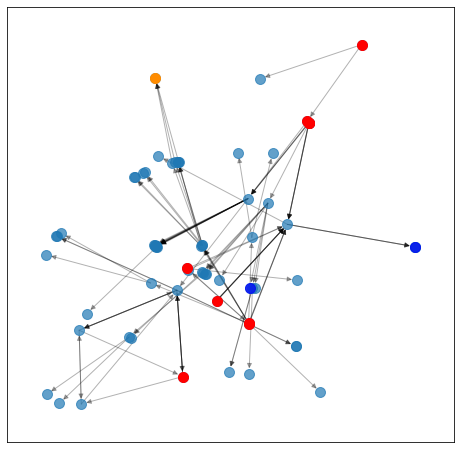

Phishing Gang Num=56


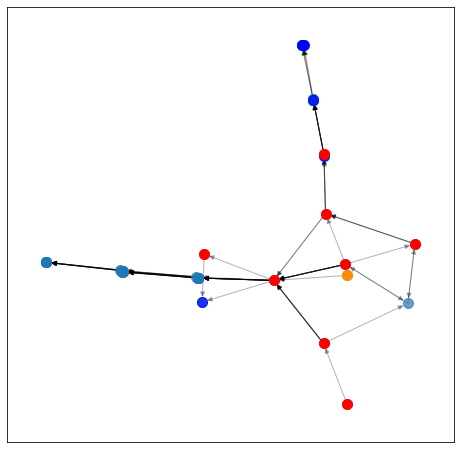

Phishing Gang Num=2


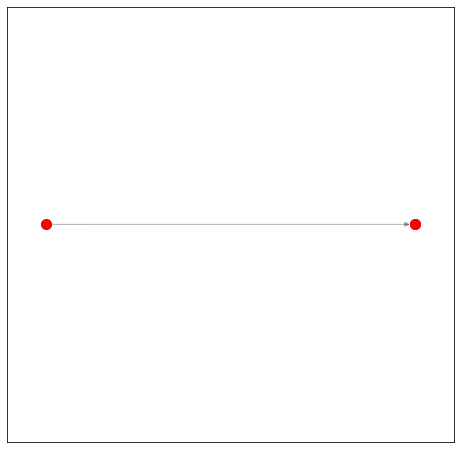

Phishing Gang Num=69


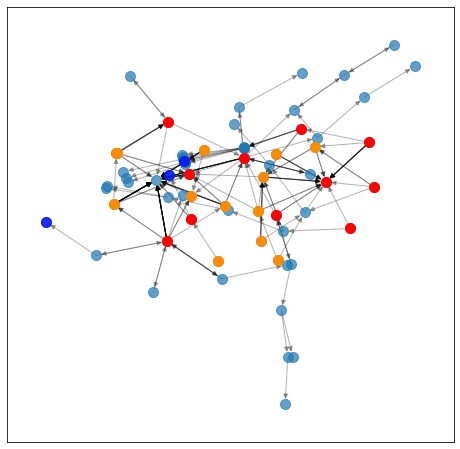

Phishing Gang Num=6


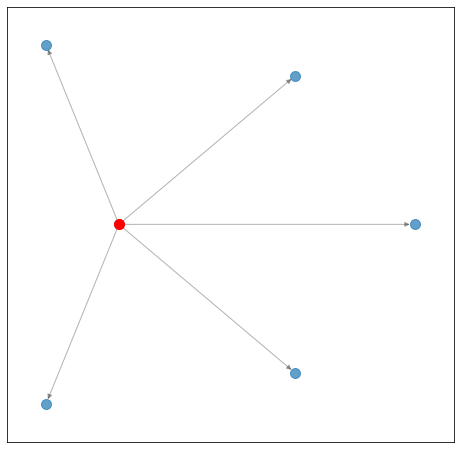

Phishing Gang Num=2


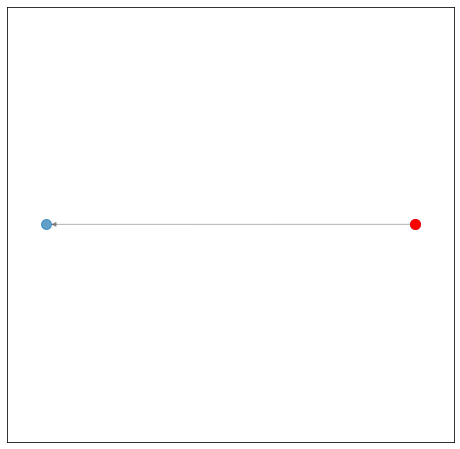

Phishing Gang Num=27


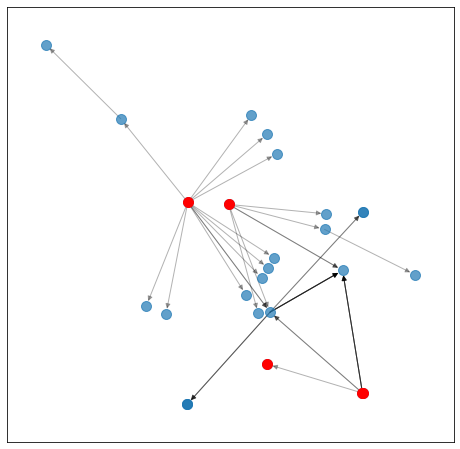

Phishing Gang Num=6


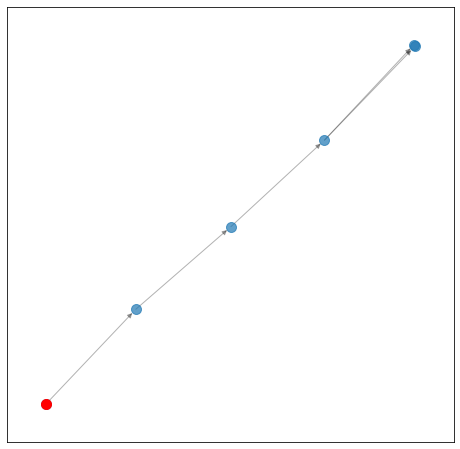

Phishing Gang Num=2


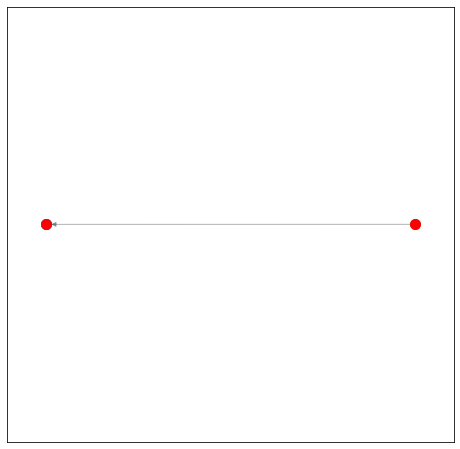

Phishing Gang Num=25


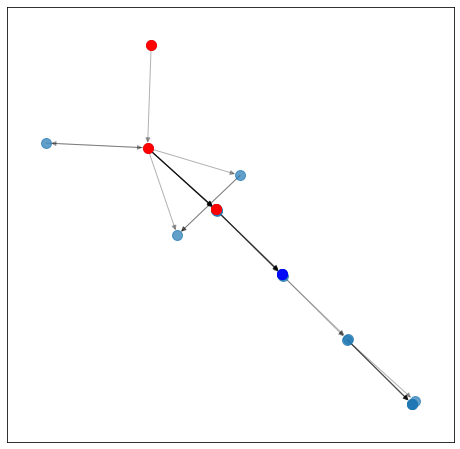

Phishing Gang Num=2


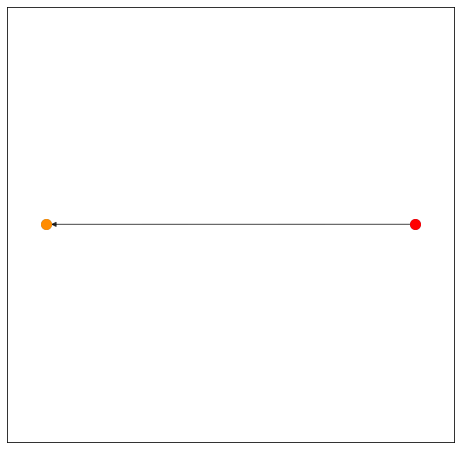

Phishing Gang Num=2


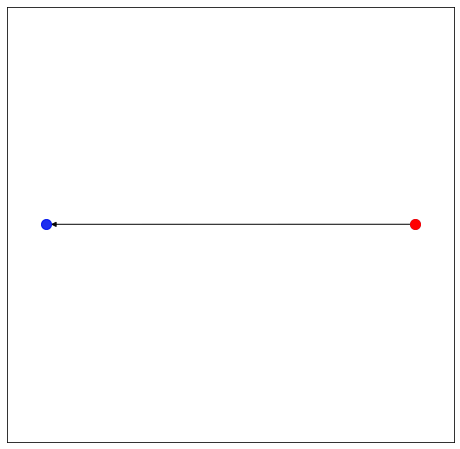

Phishing Gang Num=7


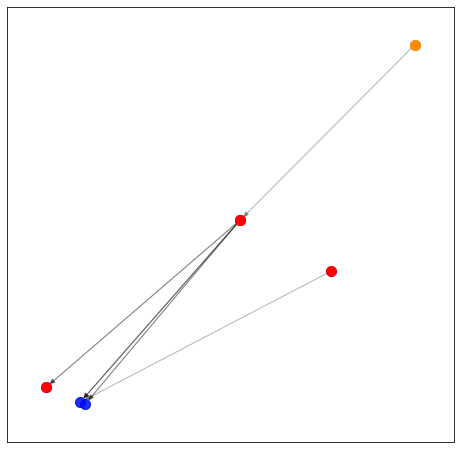

Phishing Gang Num=2


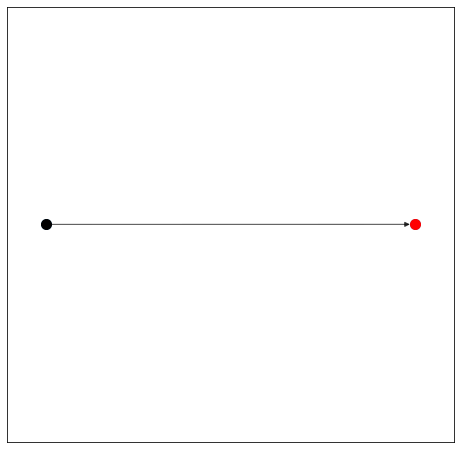

Phishing Gang Num=2


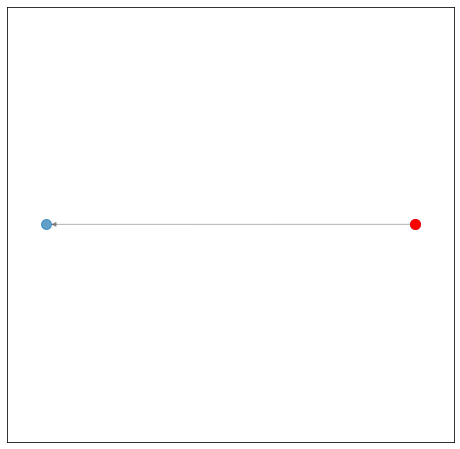

Phishing Gang Num=2


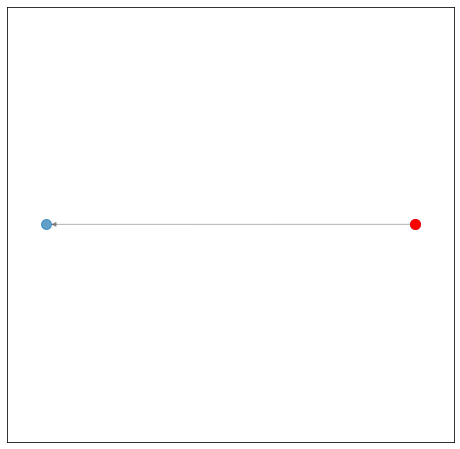

Phishing Gang Num=4


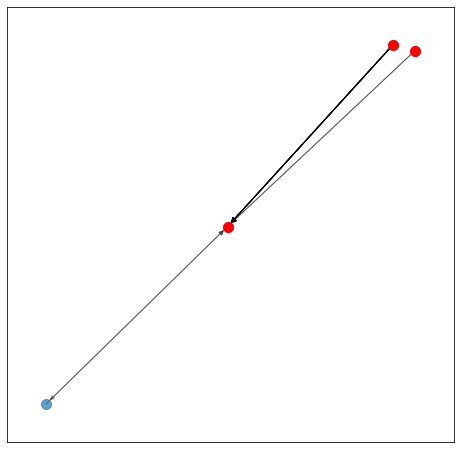

Phishing Gang Num=5


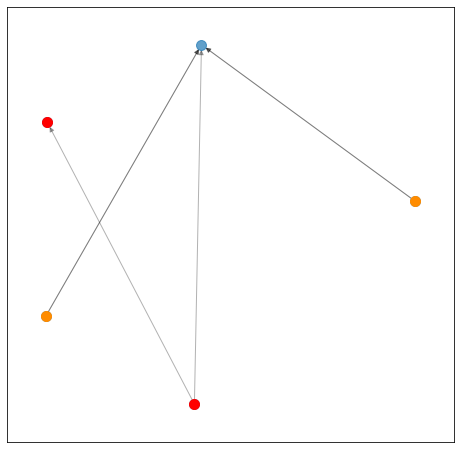

Phishing Gang Num=3


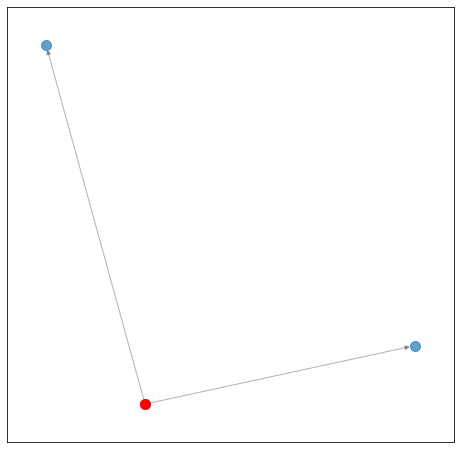

Phishing Gang Num=5


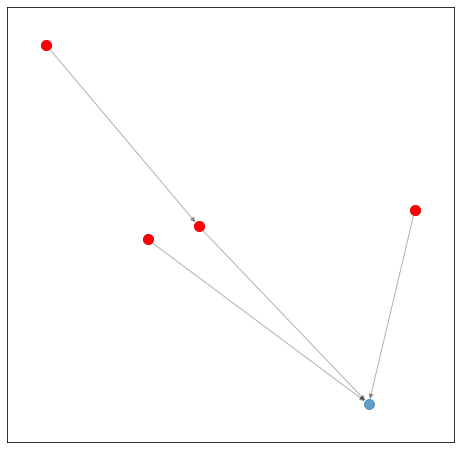

Phishing Gang Num=6


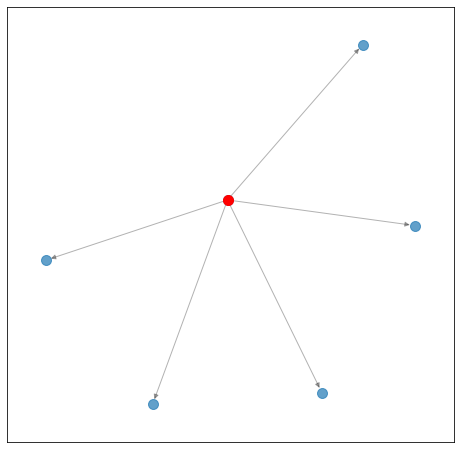

Phishing Gang Num=5


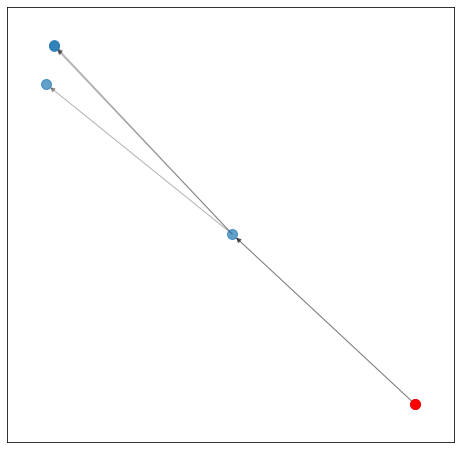

Phishing Gang Num=7


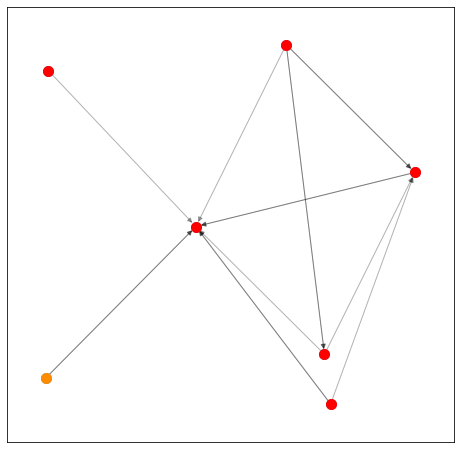

Phishing Gang Num=5


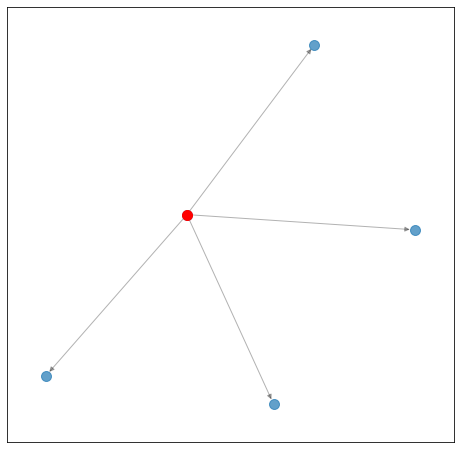

Phishing Gang Num=11


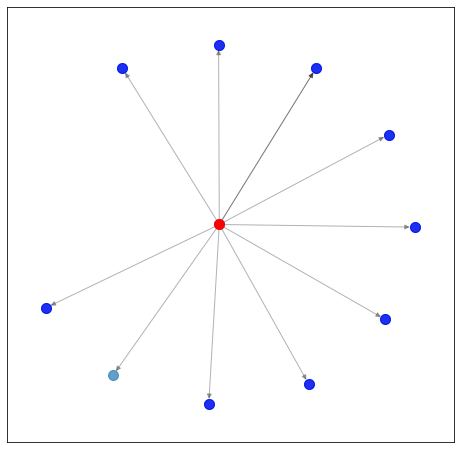

Phishing Gang Num=3


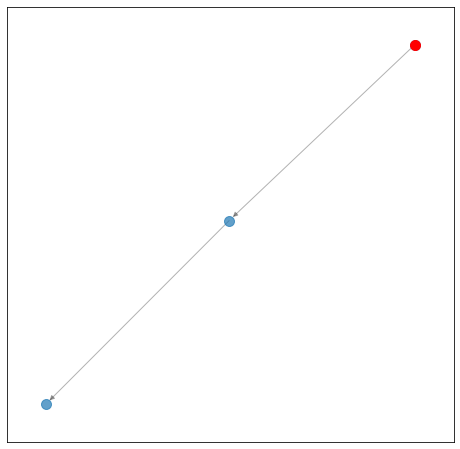

Phishing Gang Num=26


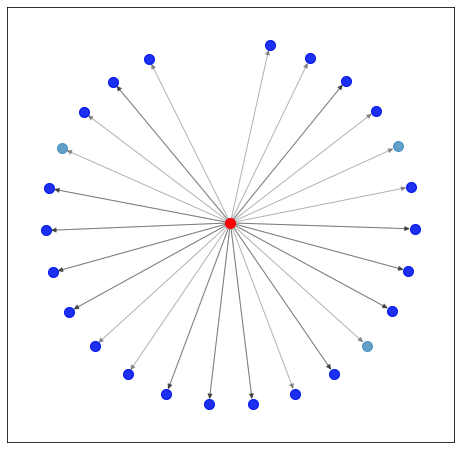

Phishing Gang Num=6


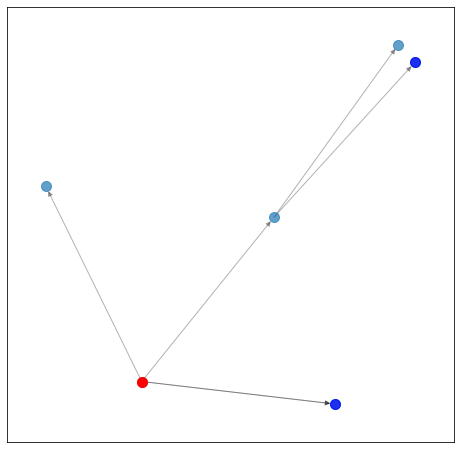

Phishing Gang Num=2


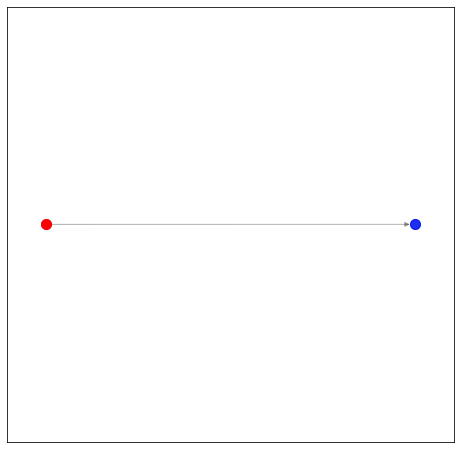

Phishing Gang Num=13


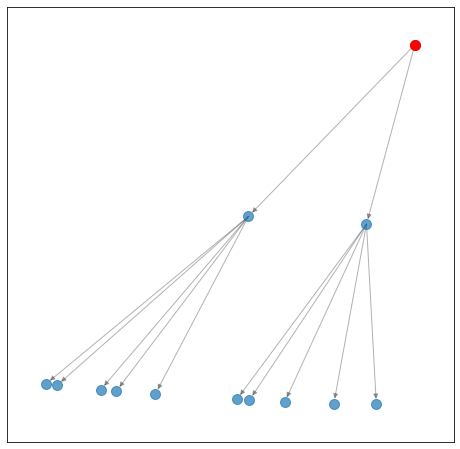

Phishing Gang Num=2


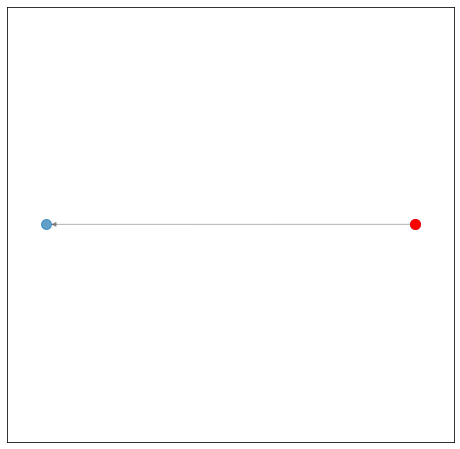

Phishing Gang Num=2


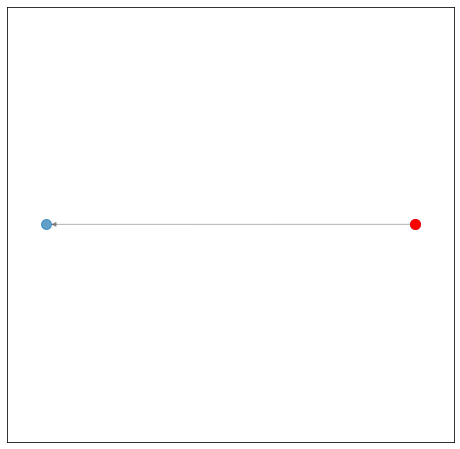

Phishing Gang Num=9


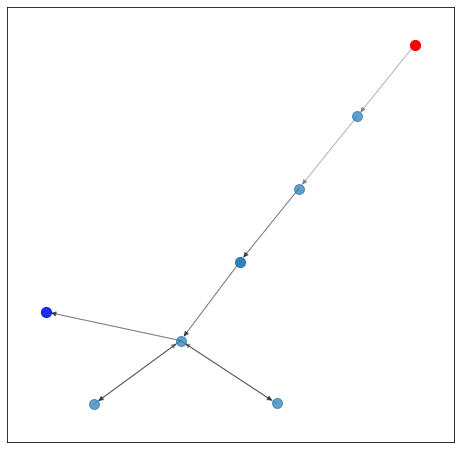

Phishing Gang Num=3


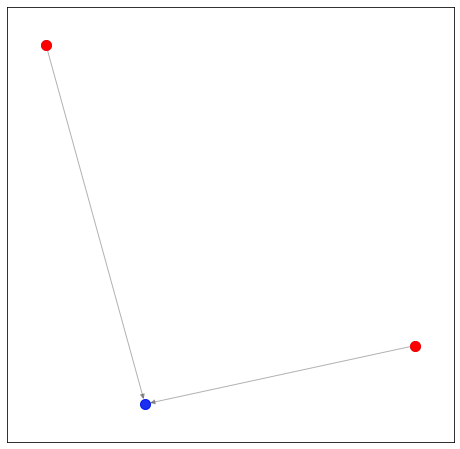

Phishing Gang Num=57


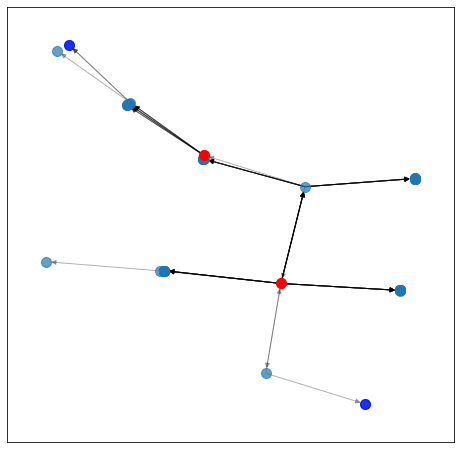

Phishing Gang Num=7


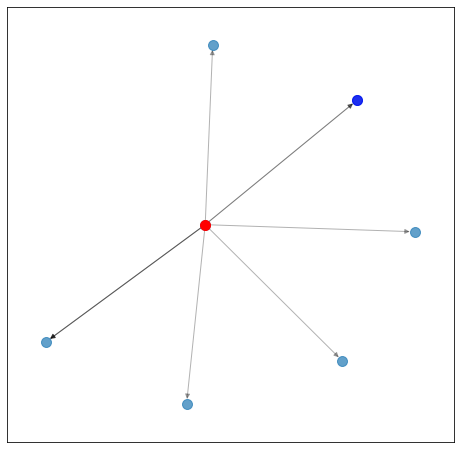

Phishing Gang Num=3


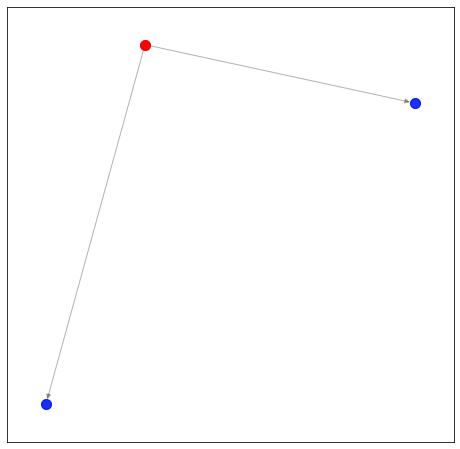

Phishing Gang Num=2


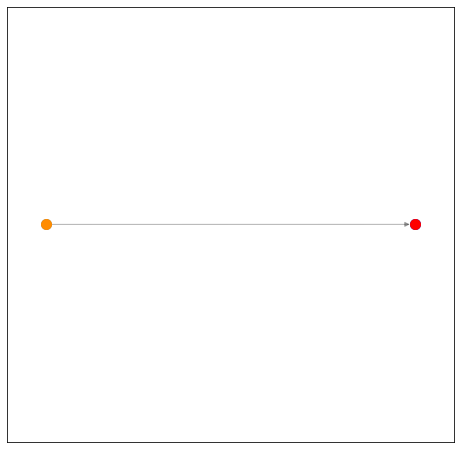

Phishing Gang Num=2


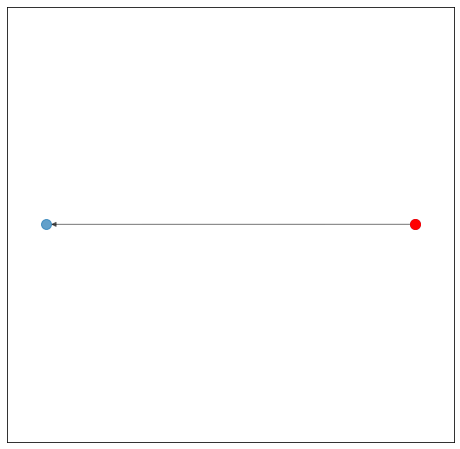

Phishing Gang Num=9


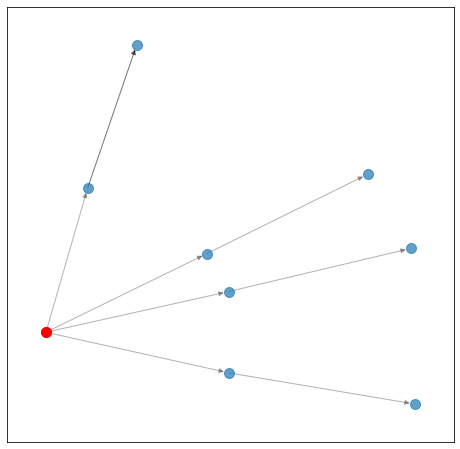

Phishing Gang Num=29


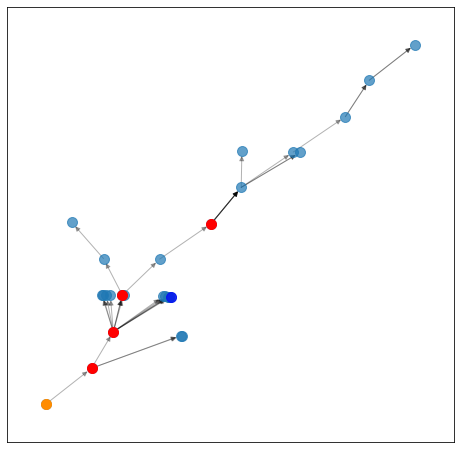

Phishing Gang Num=2


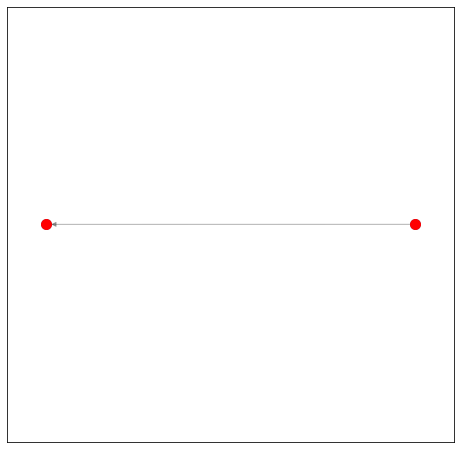

Phishing Gang Num=11


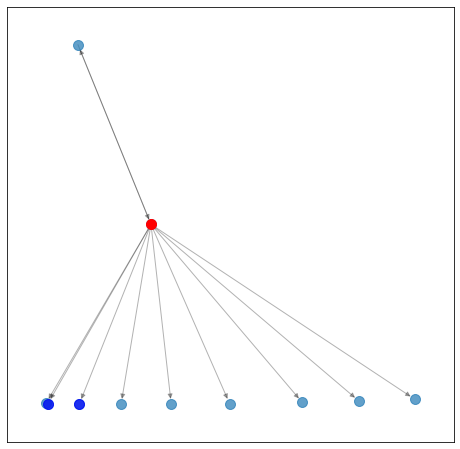

Phishing Gang Num=55


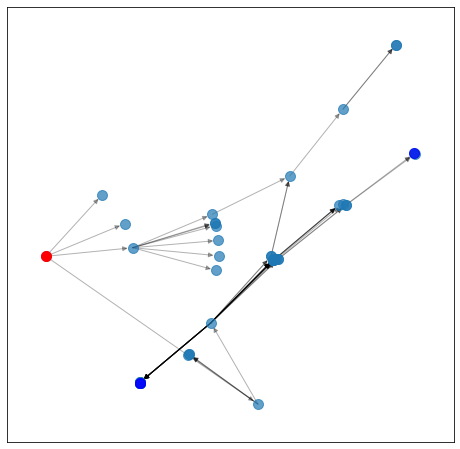

Phishing Gang Num=3


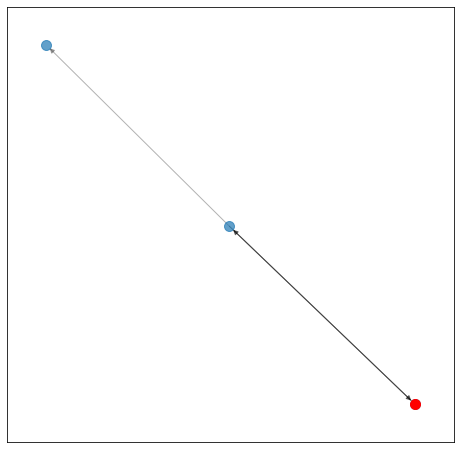

Phishing Gang Num=23


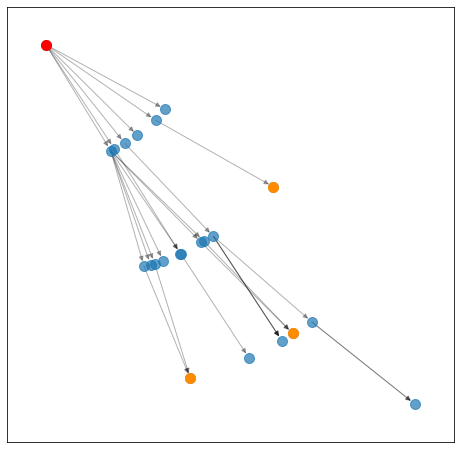

Phishing Gang Num=24


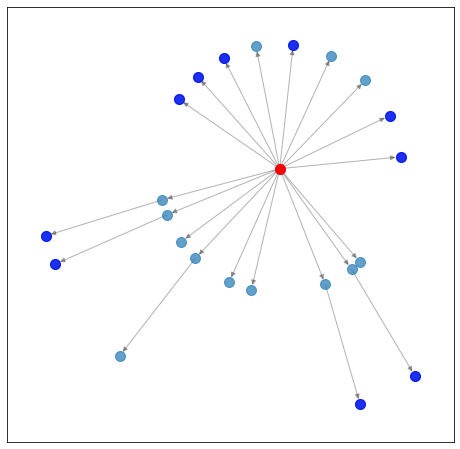

Phishing Gang Num=2


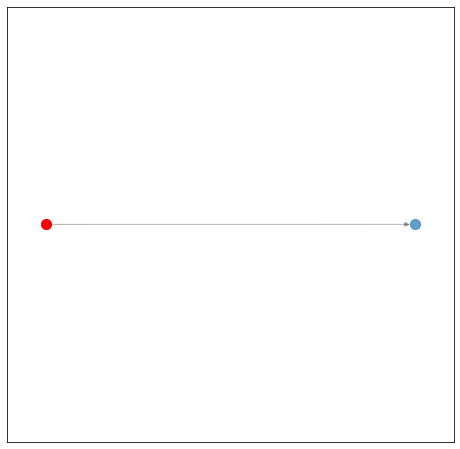

Phishing Gang Num=23


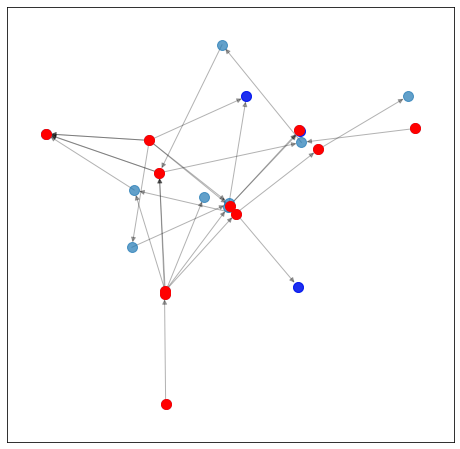

Phishing Gang Num=5


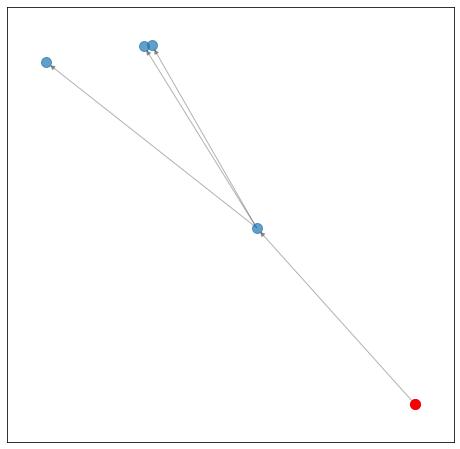

Phishing Gang Num=5


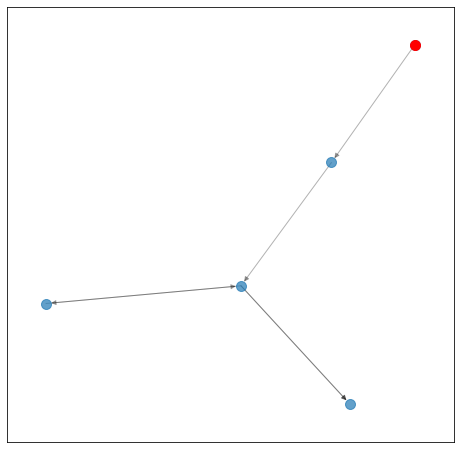

Phishing Gang Num=4


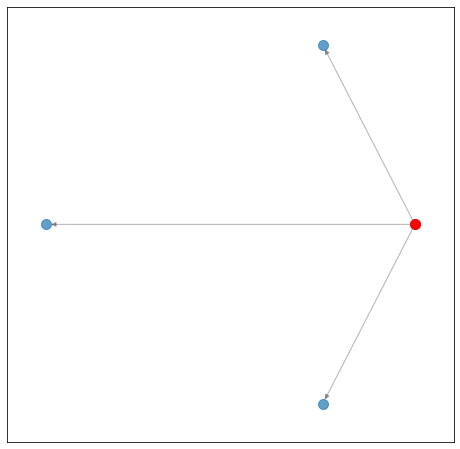

Phishing Gang Num=11


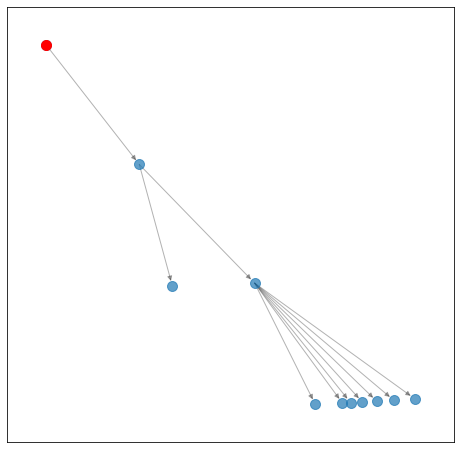

Phishing Gang Num=25


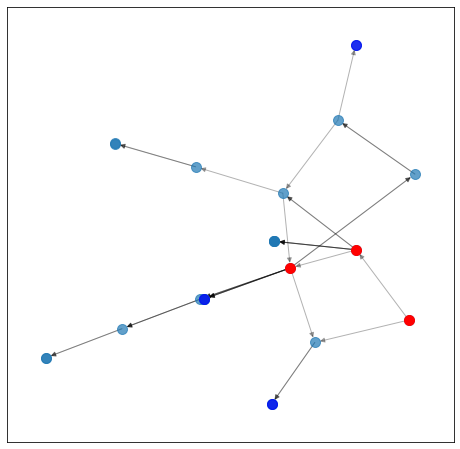

Phishing Gang Num=3


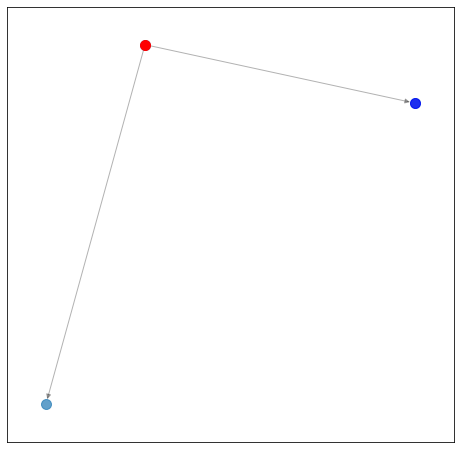

Phishing Gang Num=11


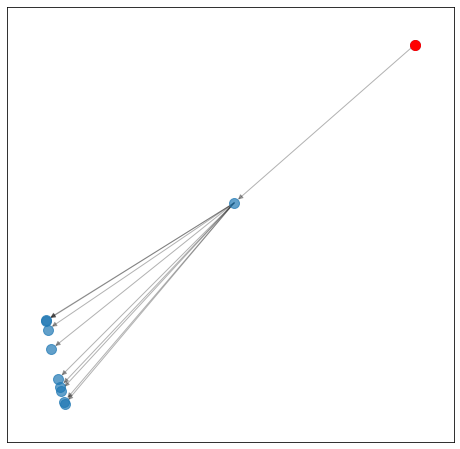

Phishing Gang Num=5


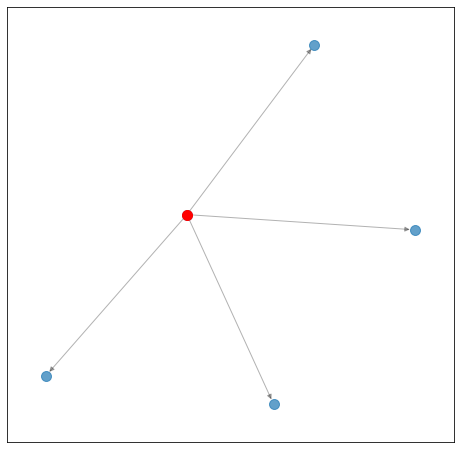

Phishing Gang Num=2


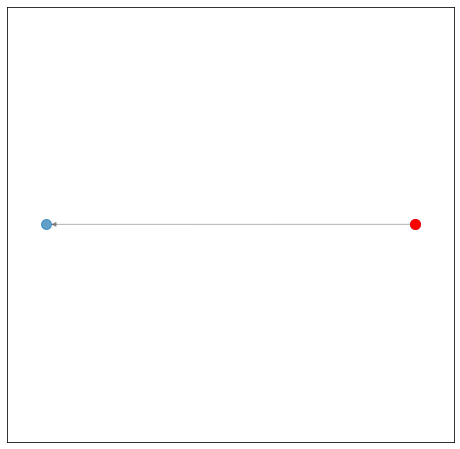

Phishing Gang Num=2


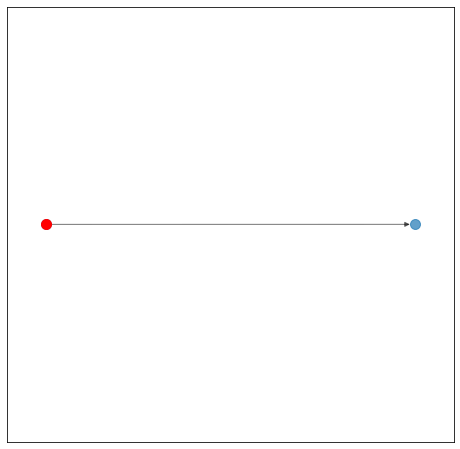

Phishing Gang Num=25


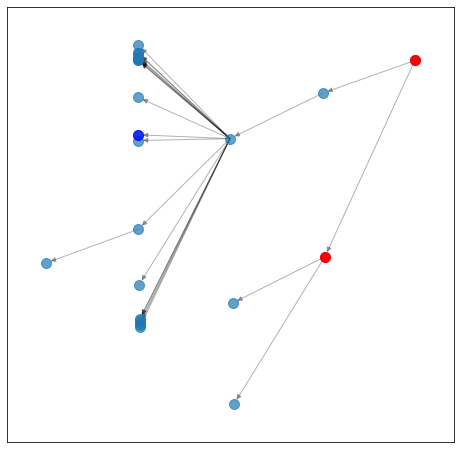

Phishing Gang Num=35


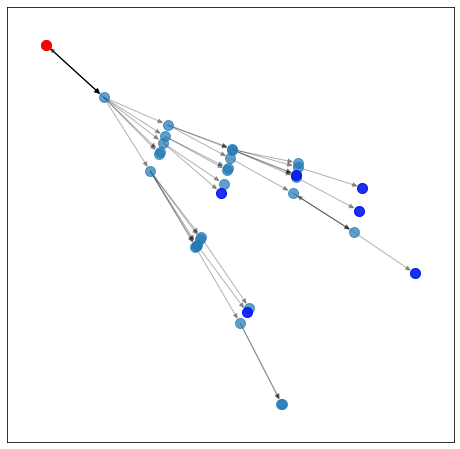

Phishing Gang Num=2


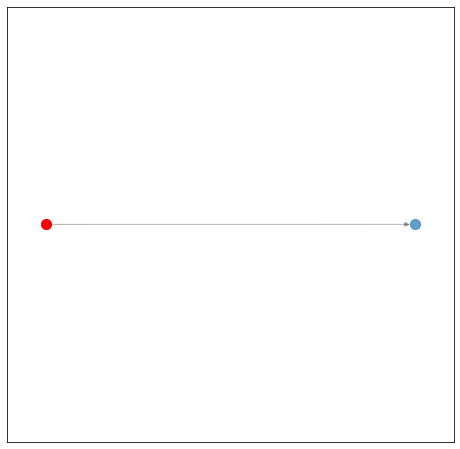

Phishing Gang Num=4


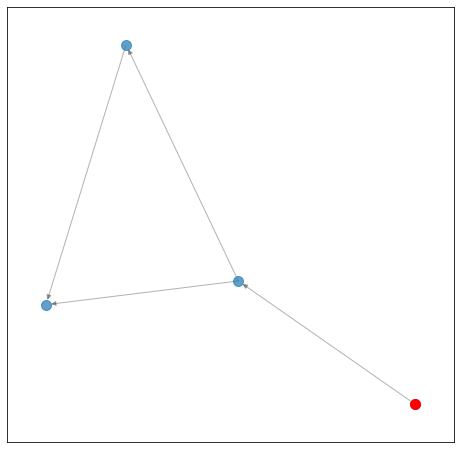

Phishing Gang Num=7


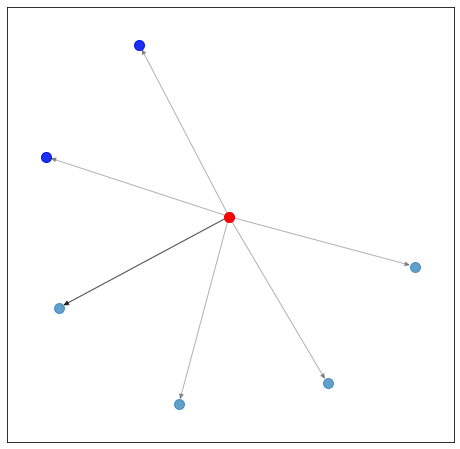

Phishing Gang Num=3


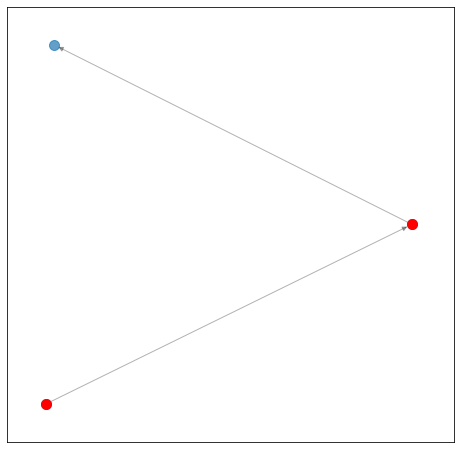

Phishing Gang Num=4


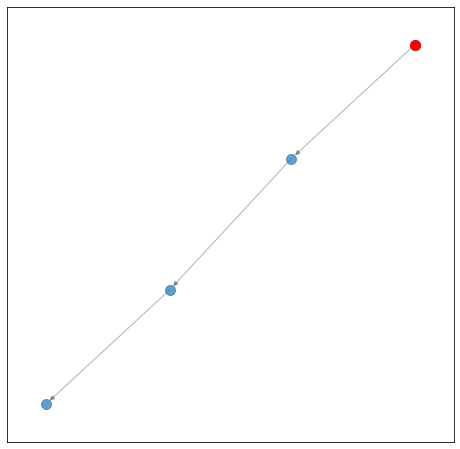

Phishing Gang Num=4


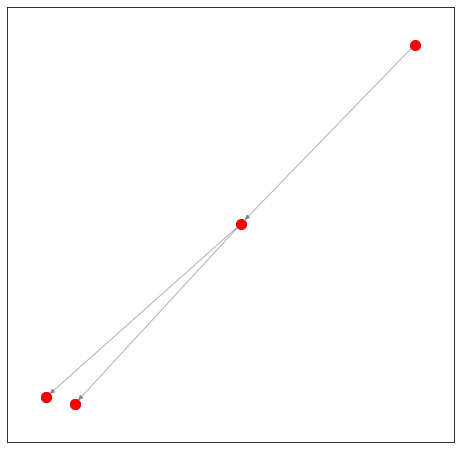

Phishing Gang Num=3


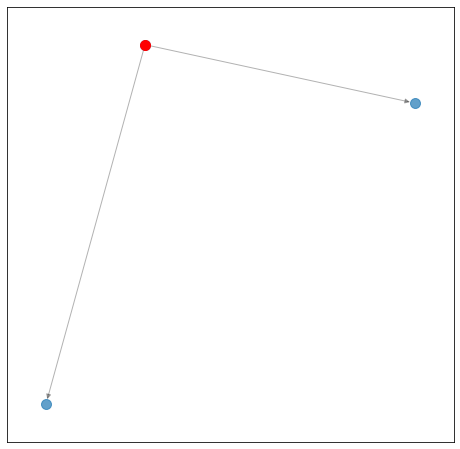

Phishing Gang Num=88


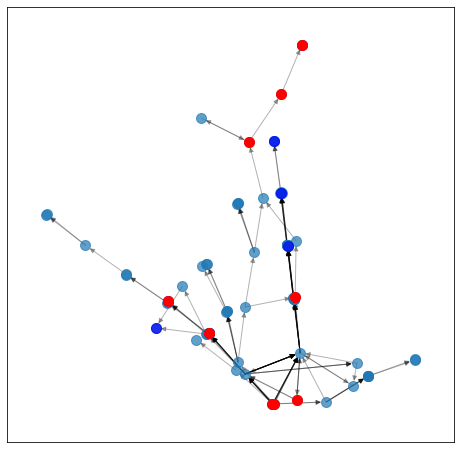

Phishing Gang Num=34


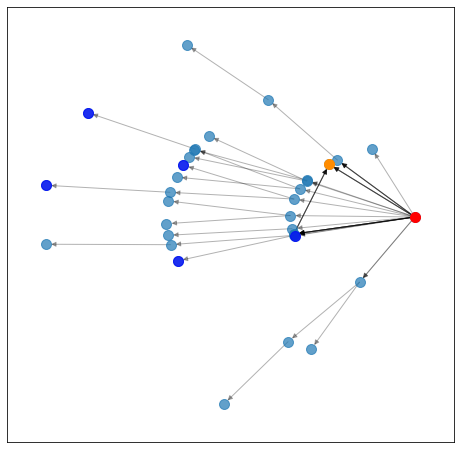

Phishing Gang Num=3


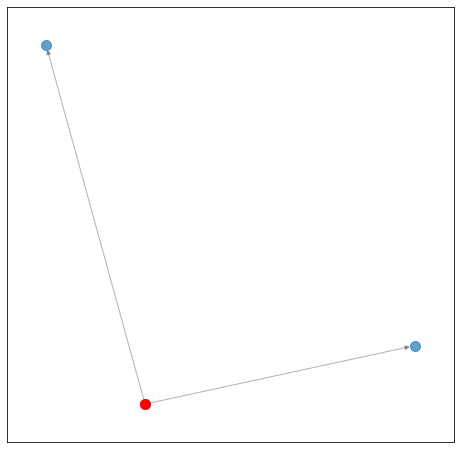

Phishing Gang Num=2


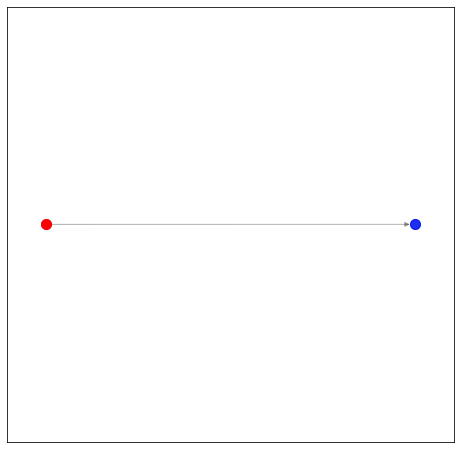

Phishing Gang Num=2


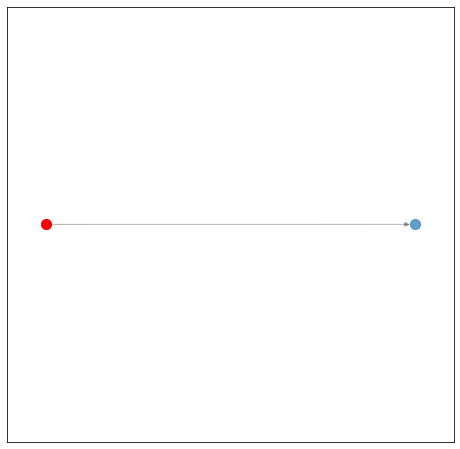

Phishing Gang Num=6


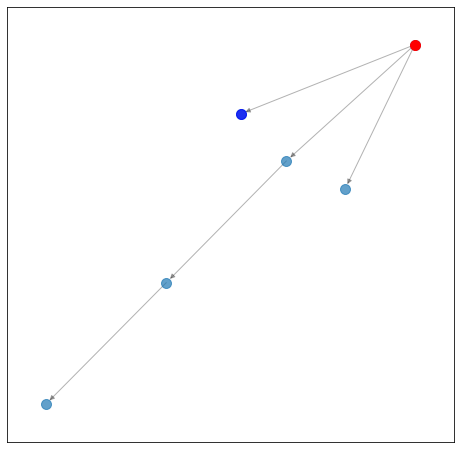

Phishing Gang Num=9


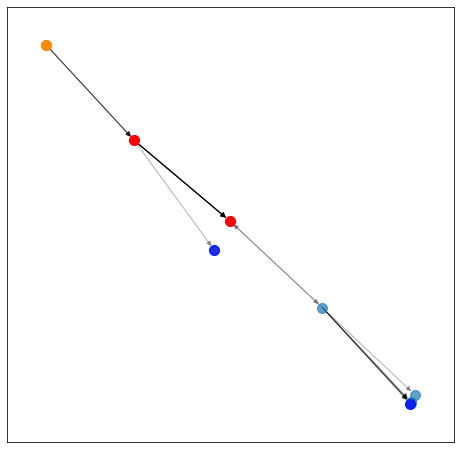

Phishing Gang Num=4


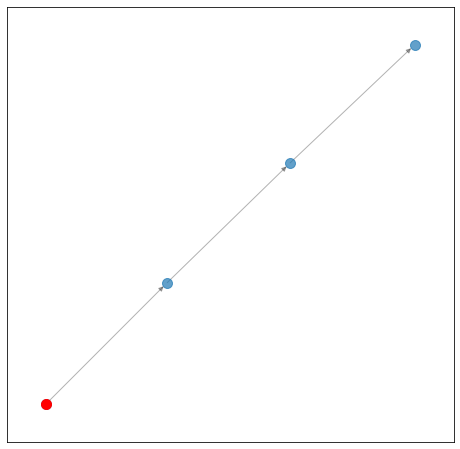

Phishing Gang Num=14


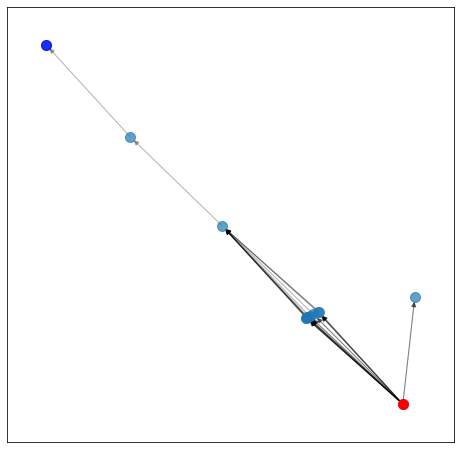

Phishing Gang Num=3


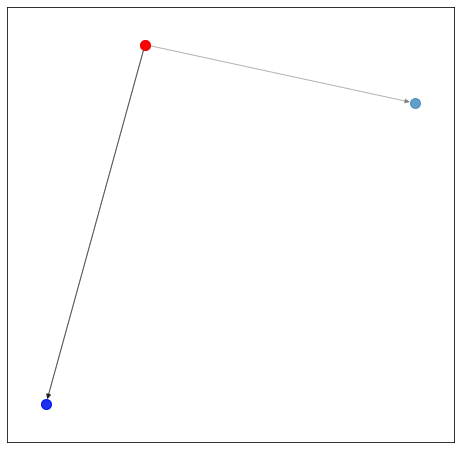

Phishing Gang Num=2


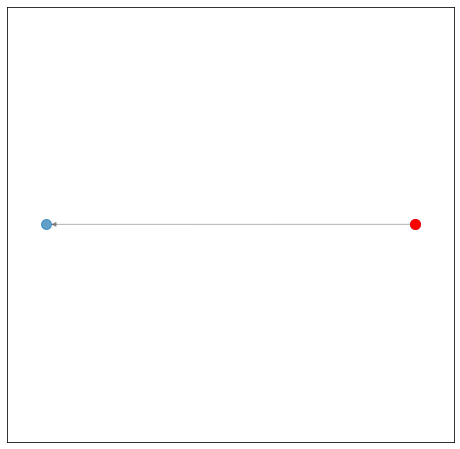

Phishing Gang Num=10


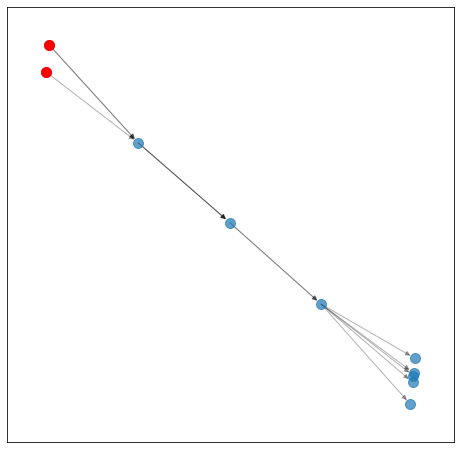

Phishing Gang Num=5


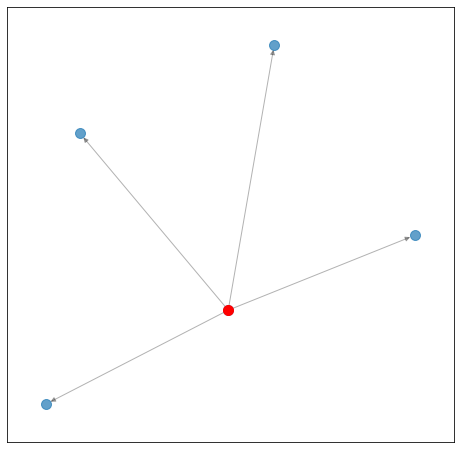

Phishing Gang Num=2


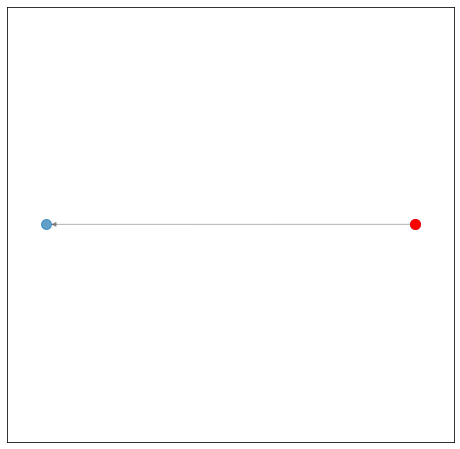

Phishing Gang Num=9


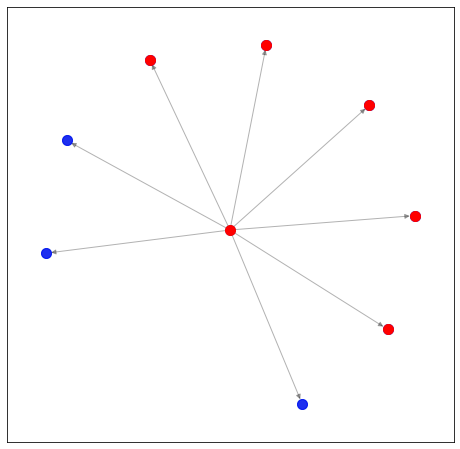

Phishing Gang Num=62


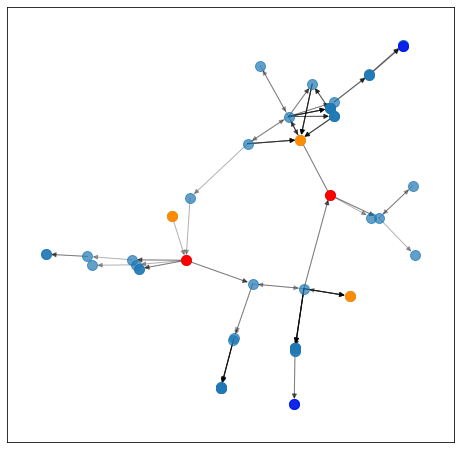

Phishing Gang Num=5


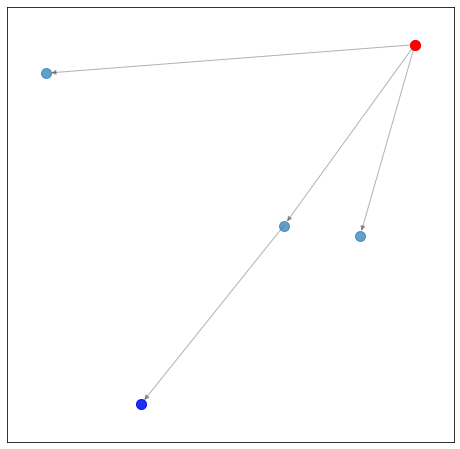

Phishing Gang Num=6


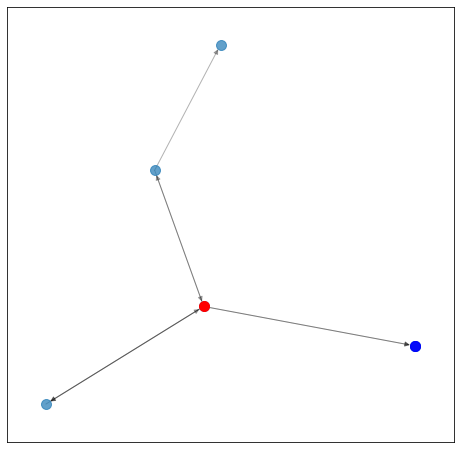

Phishing Gang Num=3


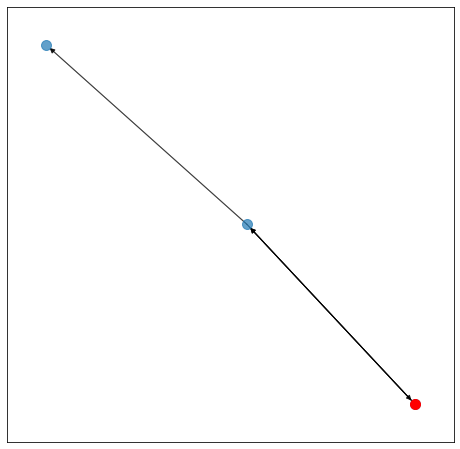

Phishing Gang Num=8


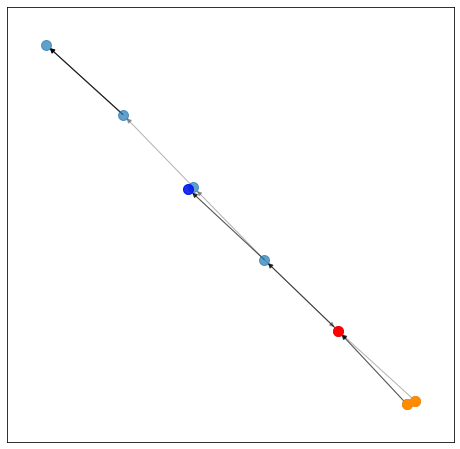

Phishing Gang Num=45


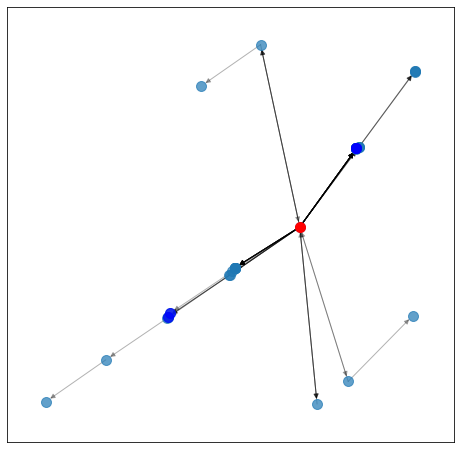

Phishing Gang Num=24


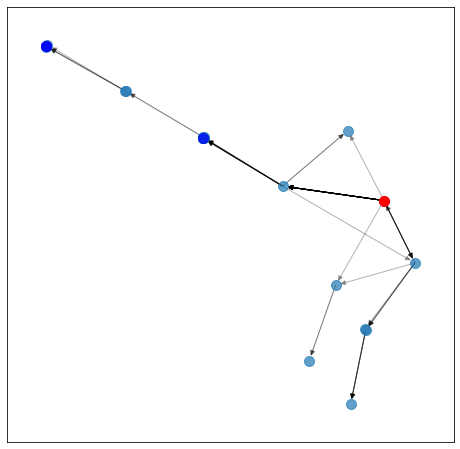

Phishing Gang Num=9


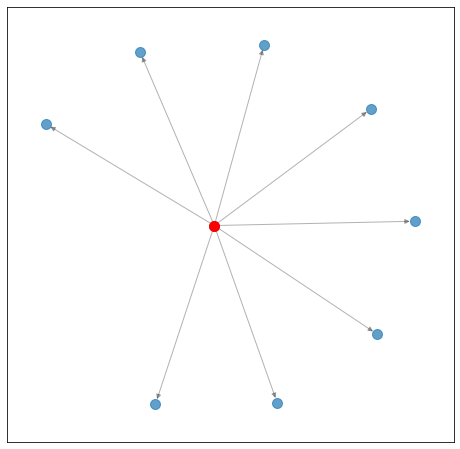

Phishing Gang Num=3


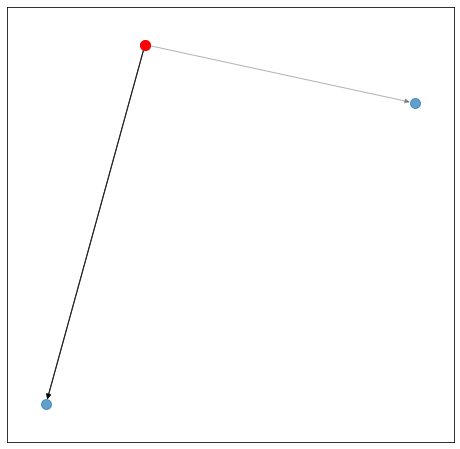

Phishing Gang Num=2


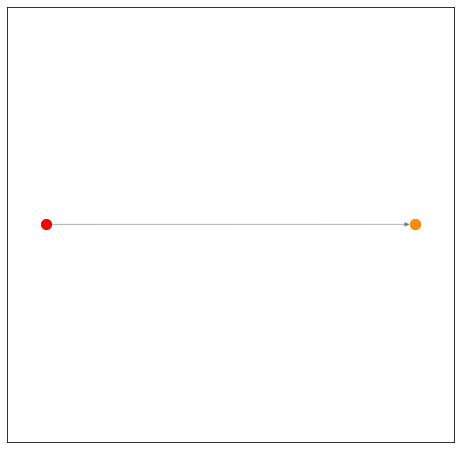

Phishing Gang Num=7


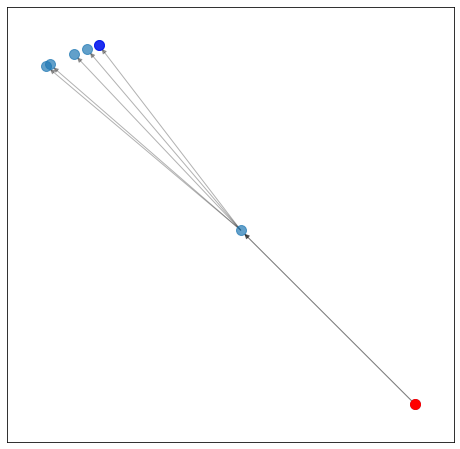

Phishing Gang Num=12


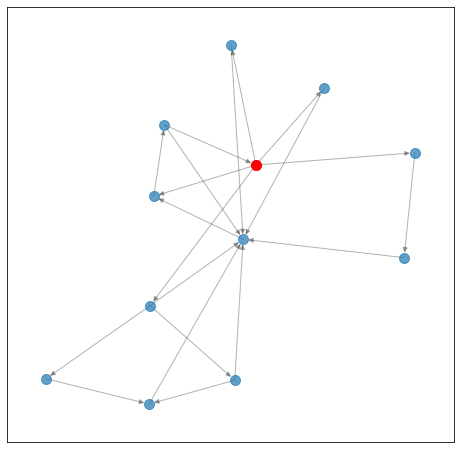

Phishing Gang Num=30


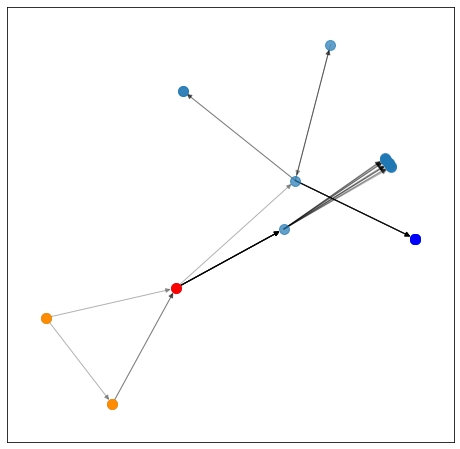

Phishing Gang Num=5


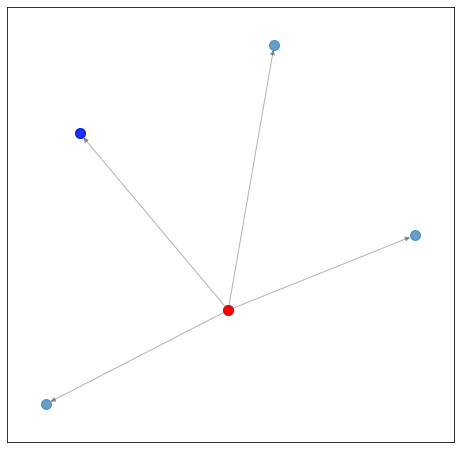

Phishing Gang Num=4


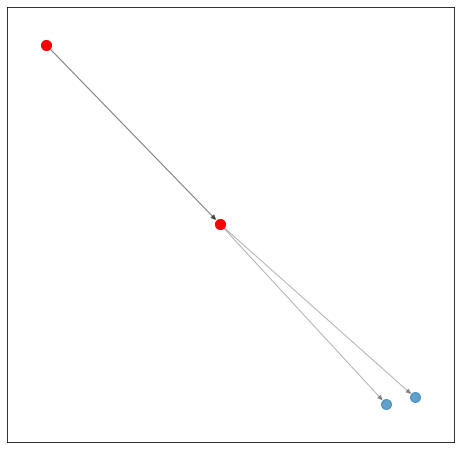

Phishing Gang Num=2


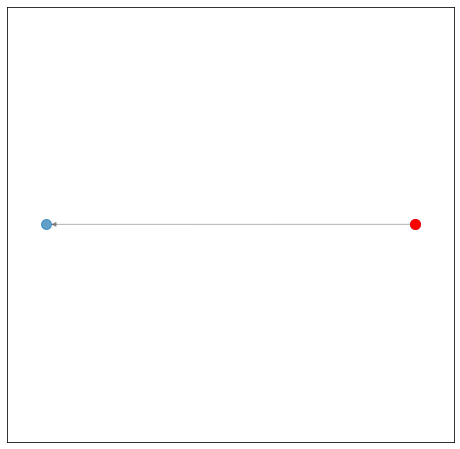

Phishing Gang Num=2


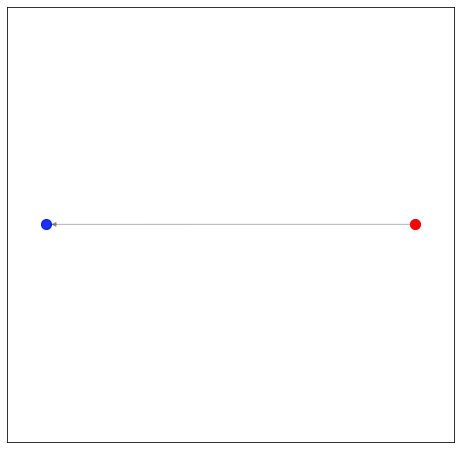

Phishing Gang Num=3


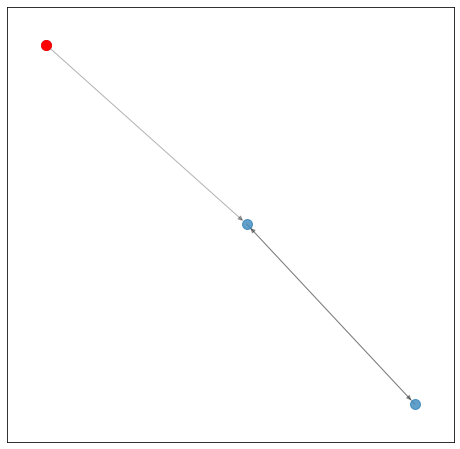

Phishing Gang Num=25


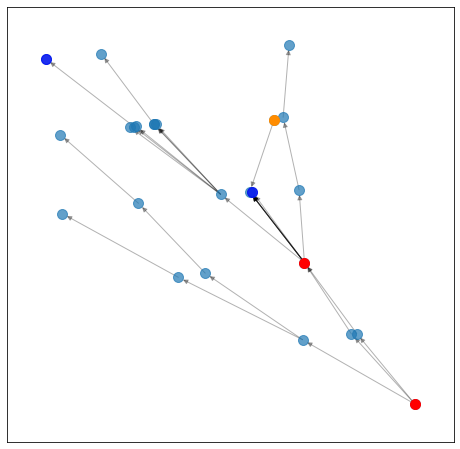

Phishing Gang Num=4


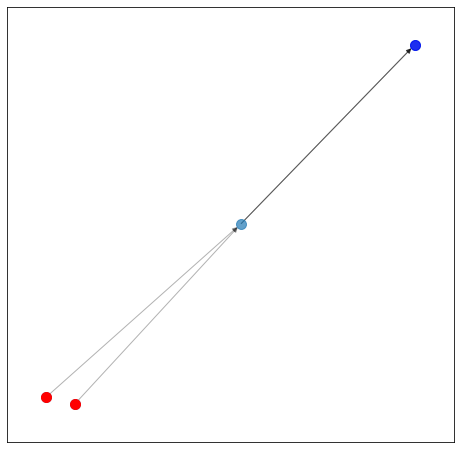

Phishing Gang Num=3


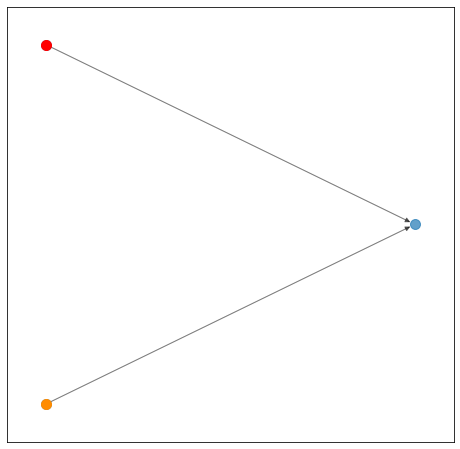

Phishing Gang Num=4


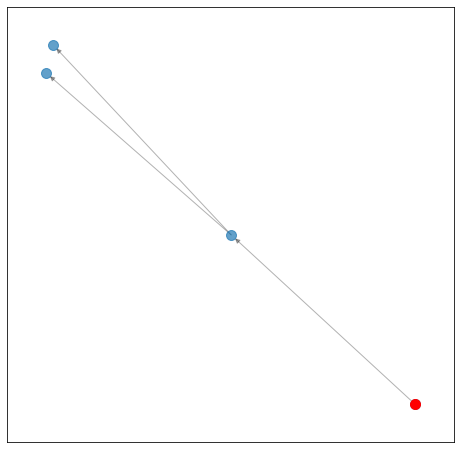

Phishing Gang Num=8


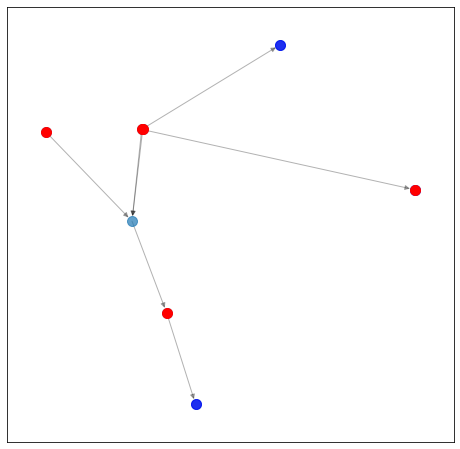

Phishing Gang Num=17


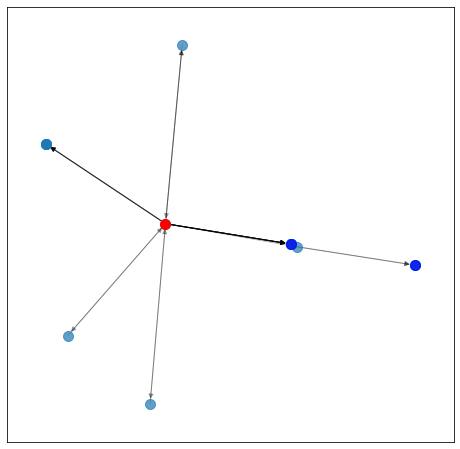

Phishing Gang Num=20


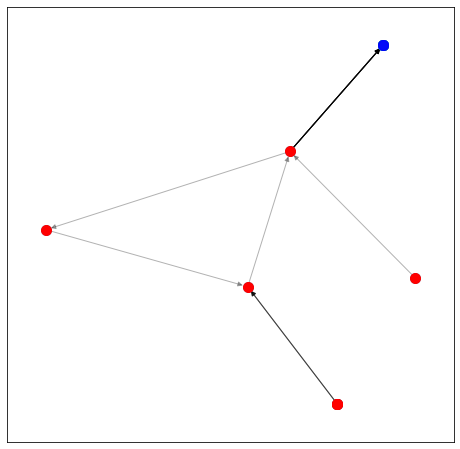

Phishing Gang Num=2


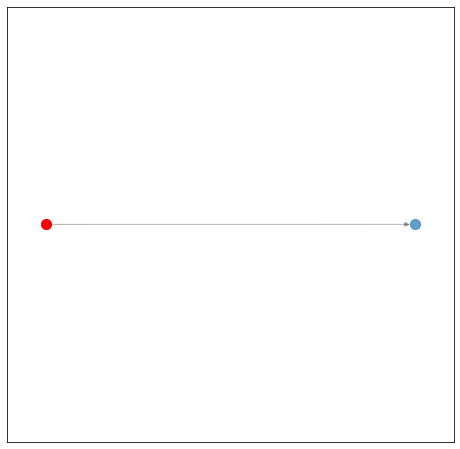

Phishing Gang Num=3


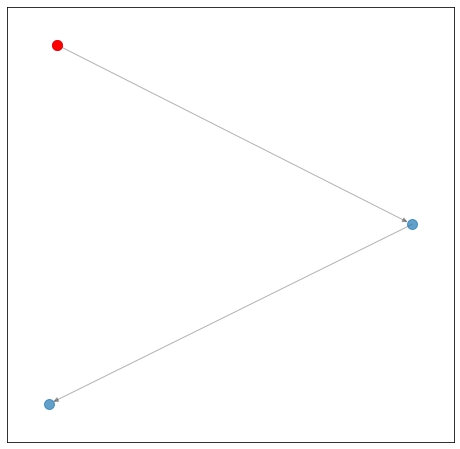

Phishing Gang Num=2


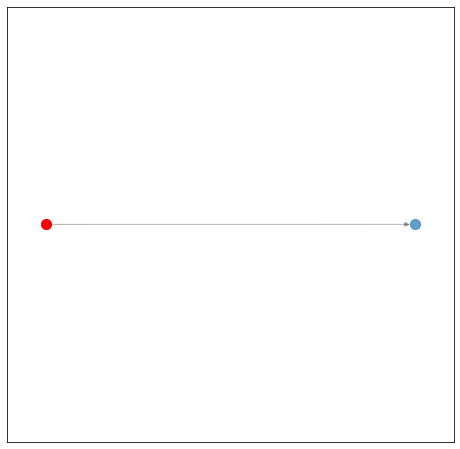

Phishing Gang Num=4


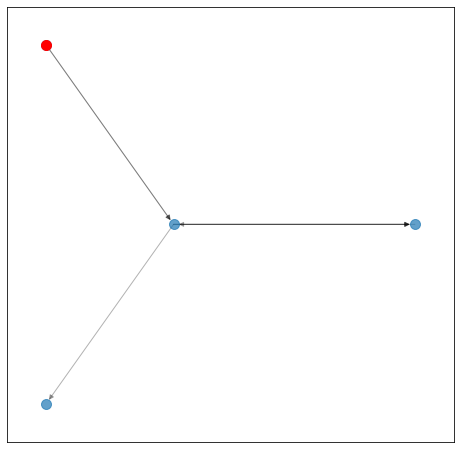

Phishing Gang Num=2


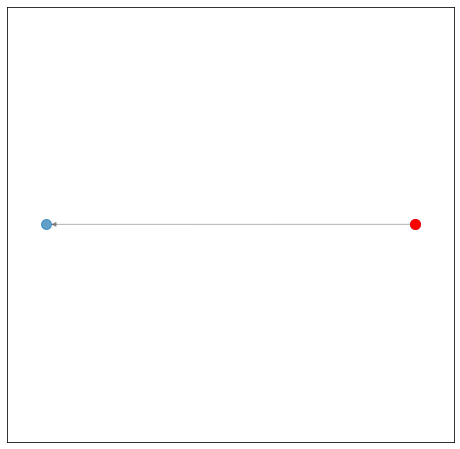

Phishing Gang Num=10


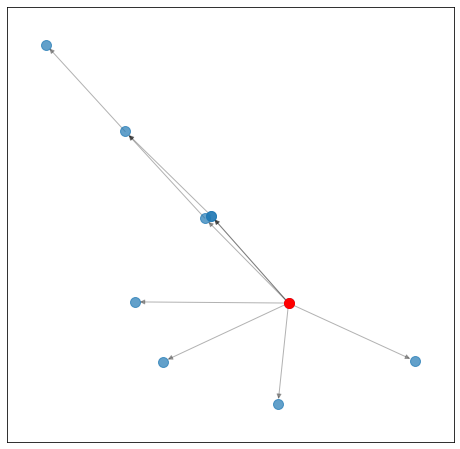

Phishing Gang Num=23


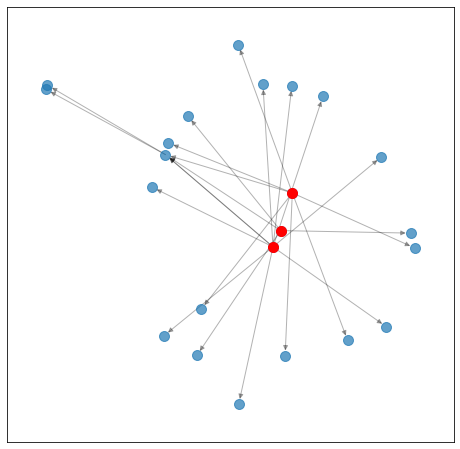

Phishing Gang Num=4


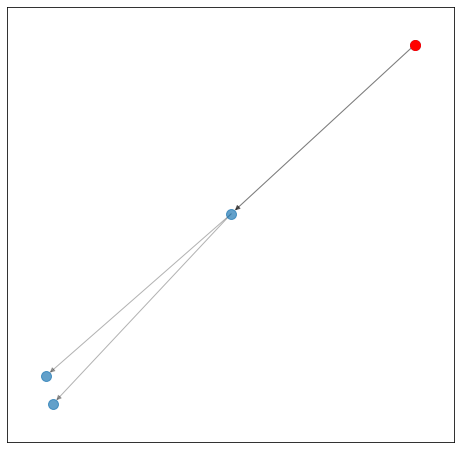

Phishing Gang Num=6


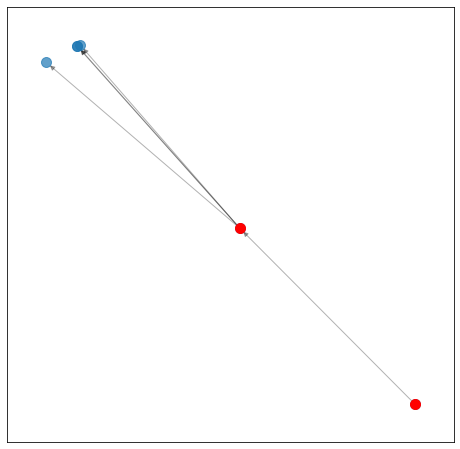

Phishing Gang Num=3


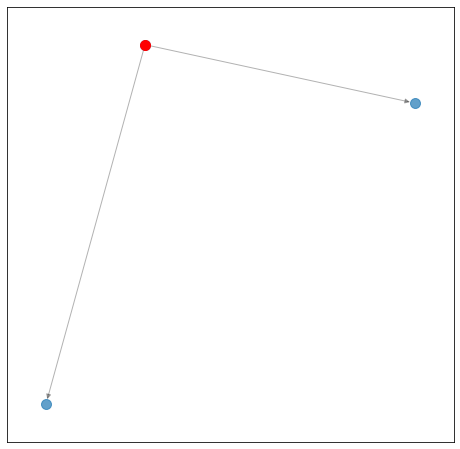

Phishing Gang Num=2


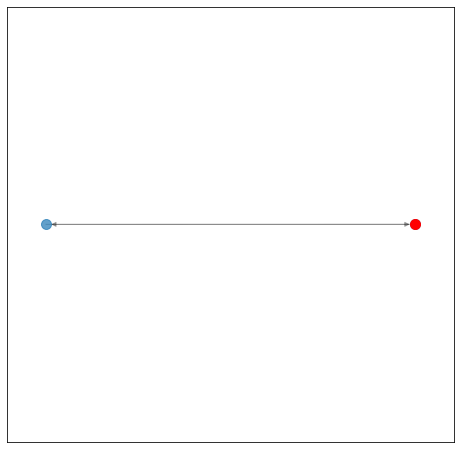

Phishing Gang Num=4


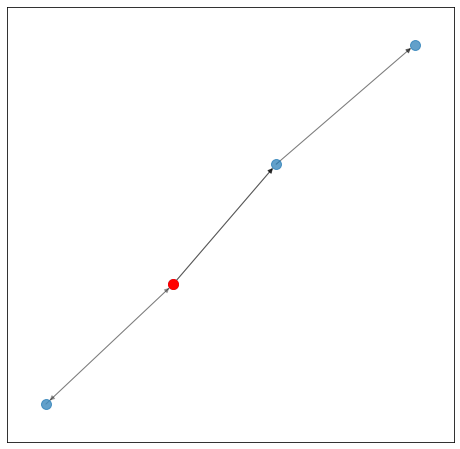

Phishing Gang Num=2


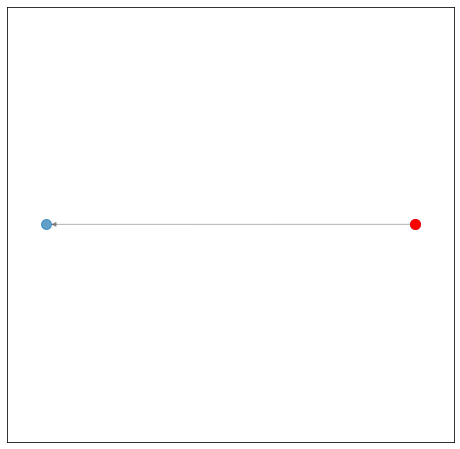

Phishing Gang Num=5


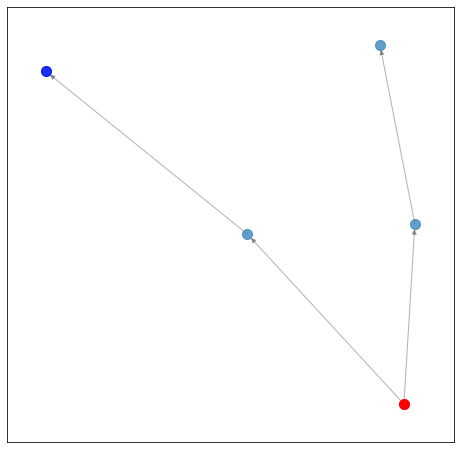

Phishing Gang Num=3


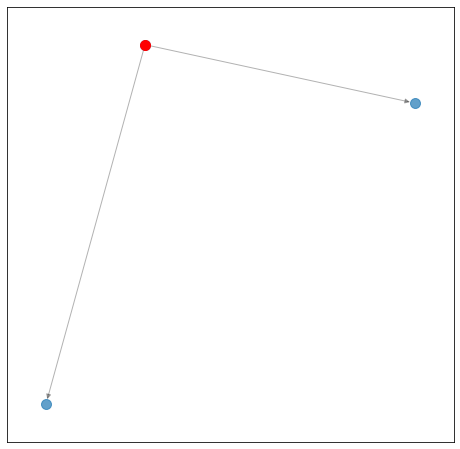

Phishing Gang Num=5


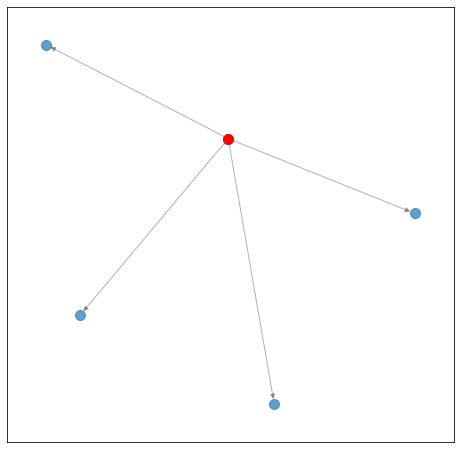

Phishing Gang Num=2


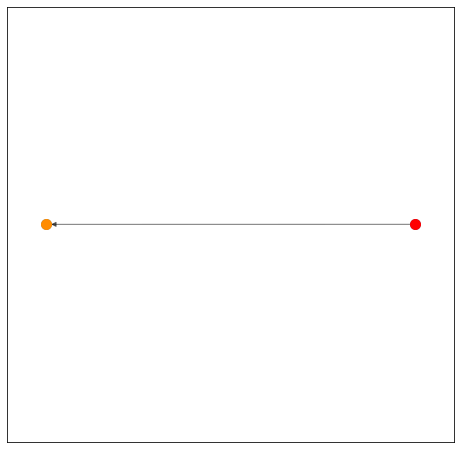

Phishing Gang Num=25


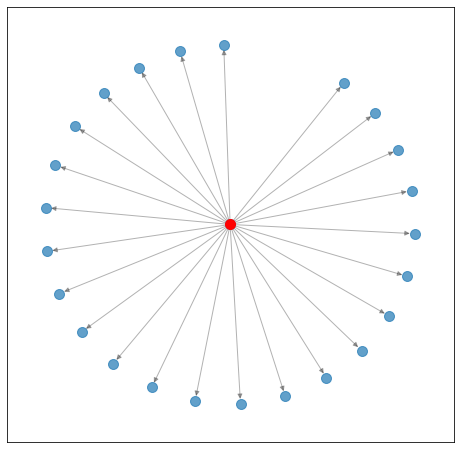

Phishing Gang Num=2


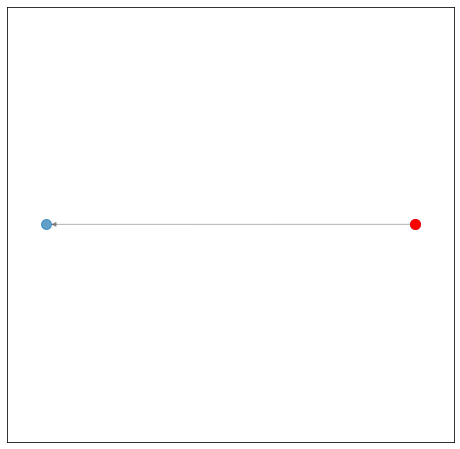

Phishing Gang Num=3


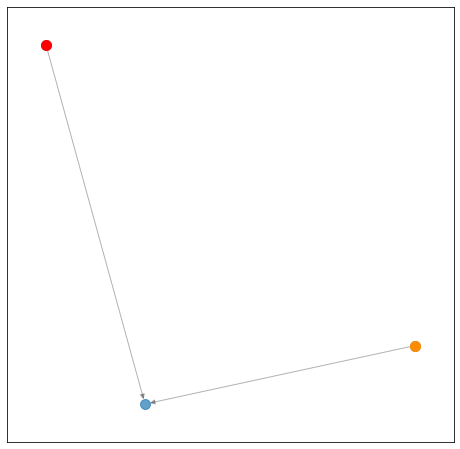

Phishing Gang Num=8


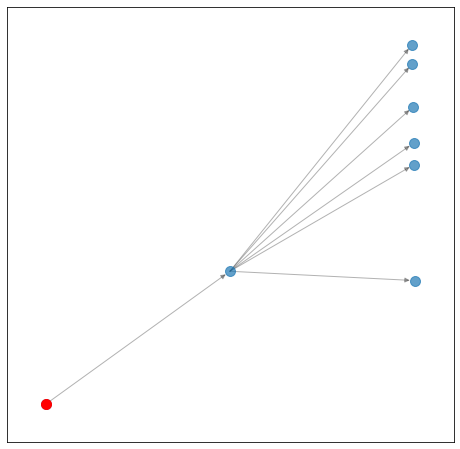

Phishing Gang Num=3


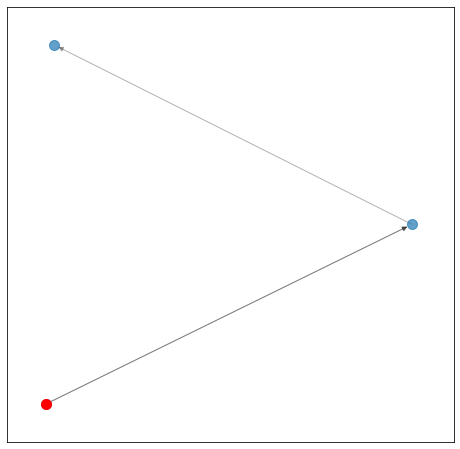

Phishing Gang Num=14


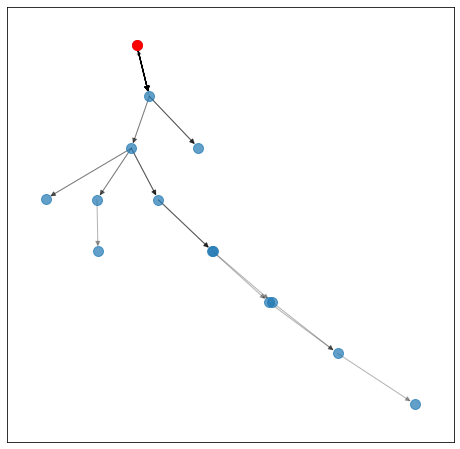

Phishing Gang Num=3


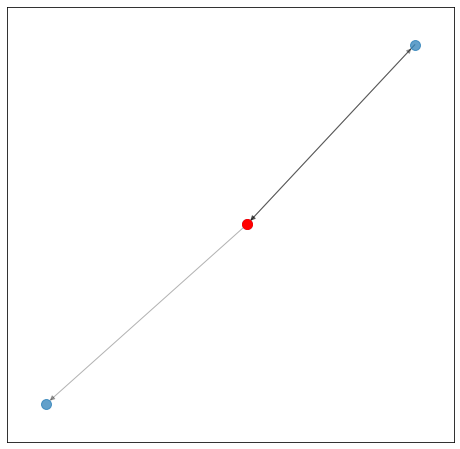

Phishing Gang Num=9


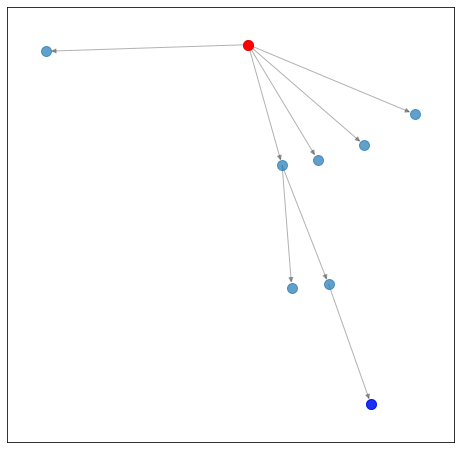

Phishing Gang Num=8


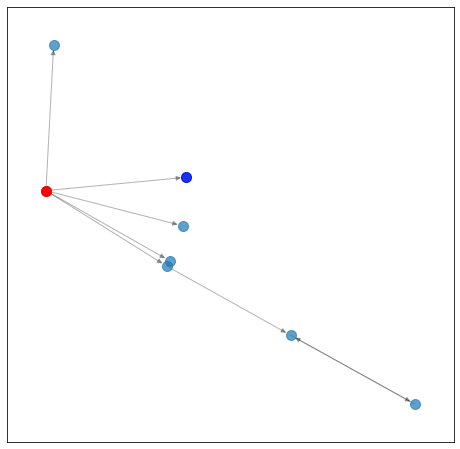

Phishing Gang Num=3


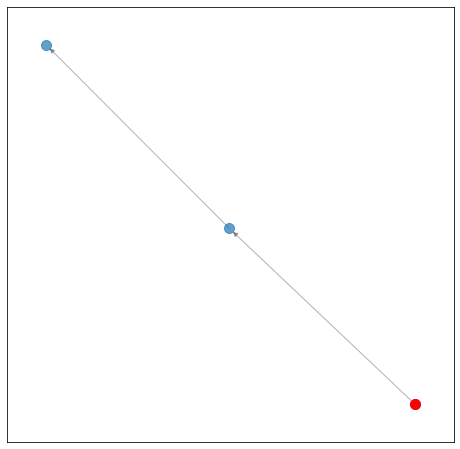

Phishing Gang Num=2


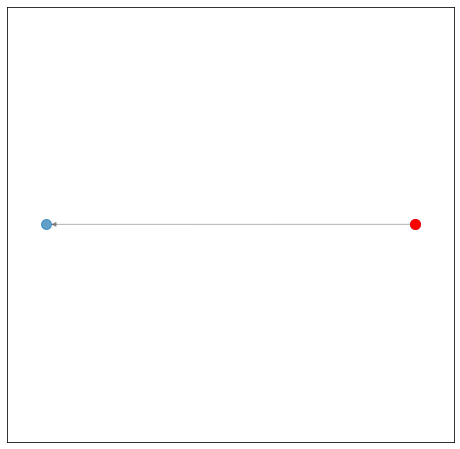

Phishing Gang Num=5


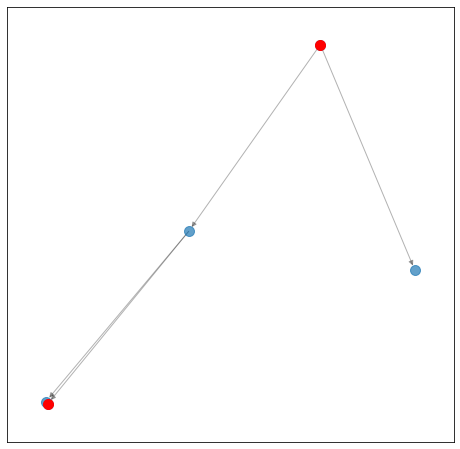

Phishing Gang Num=3


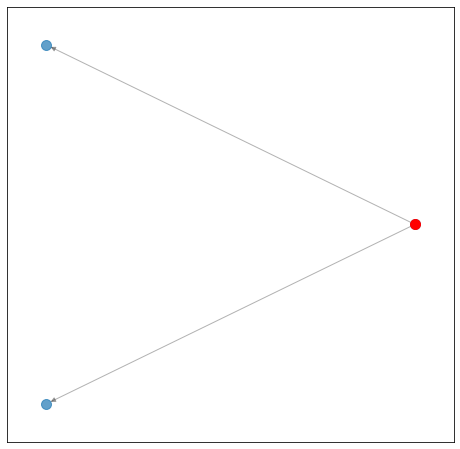

Phishing Gang Num=11


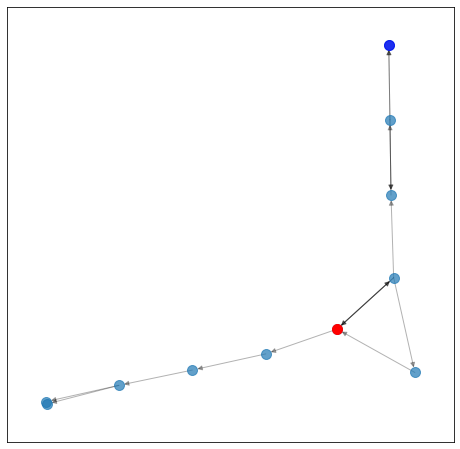

Phishing Gang Num=8


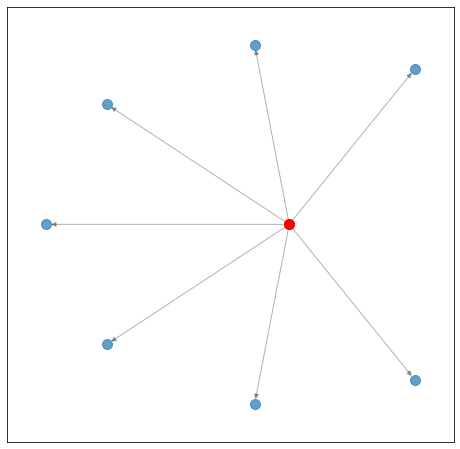

Phishing Gang Num=3


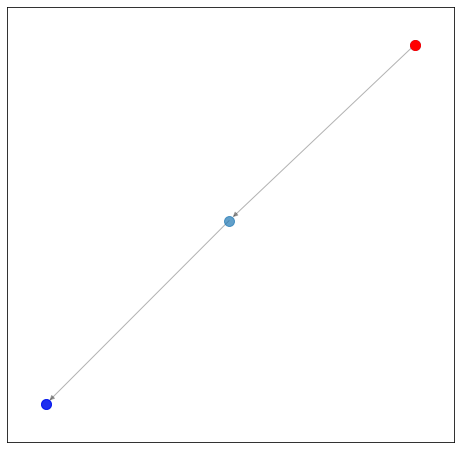

Phishing Gang Num=26


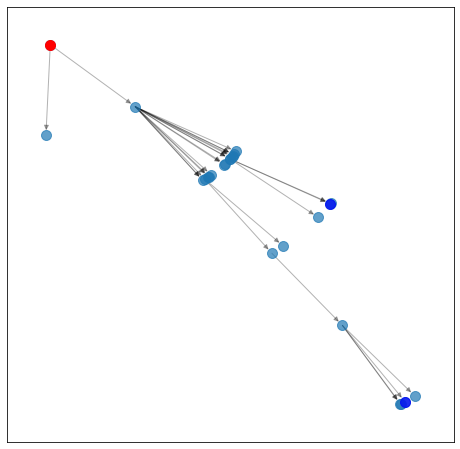

Phishing Gang Num=2


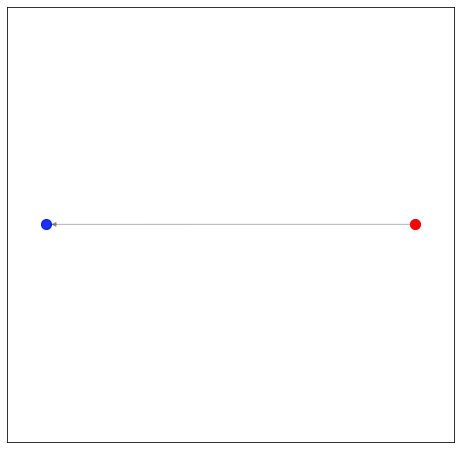

Phishing Gang Num=5


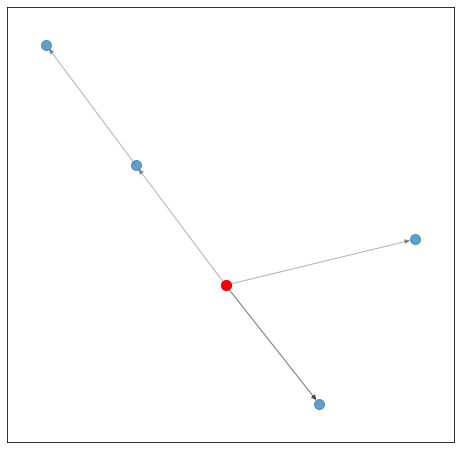

Phishing Gang Num=2


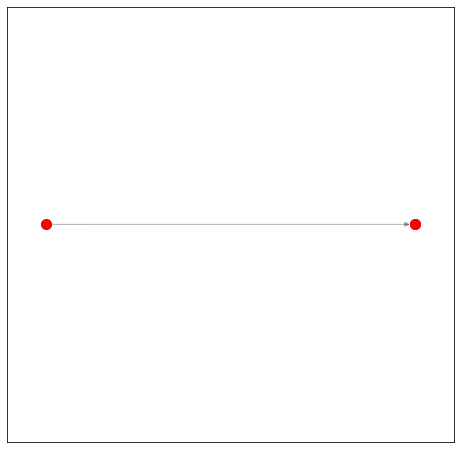

Phishing Gang Num=5


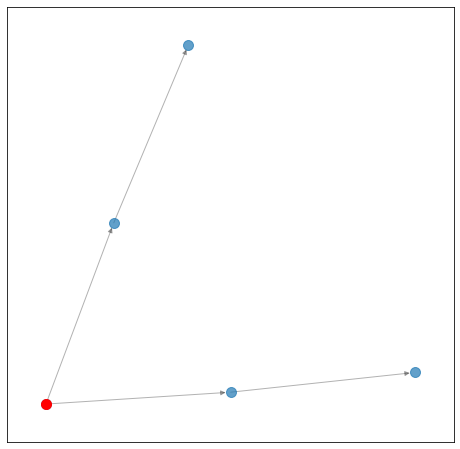

Phishing Gang Num=4


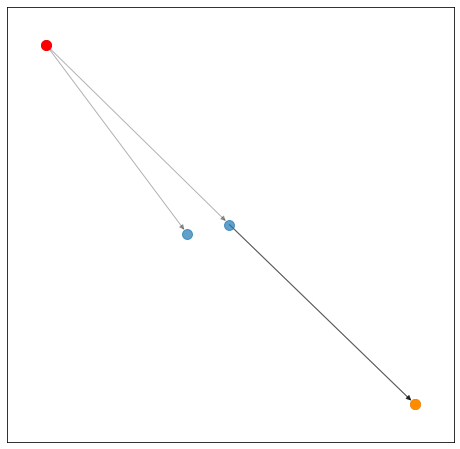

Phishing Gang Num=4


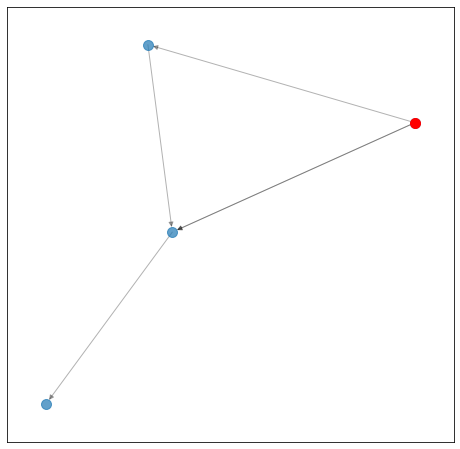

Phishing Gang Num=3


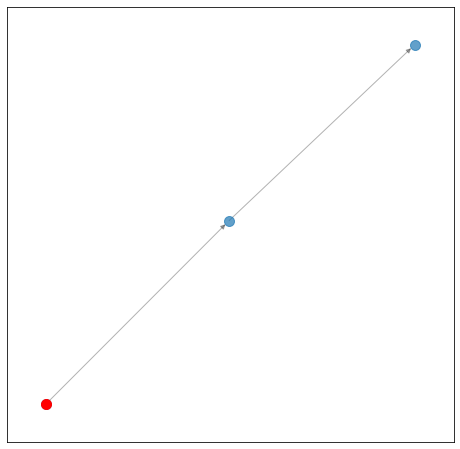

Phishing Gang Num=2


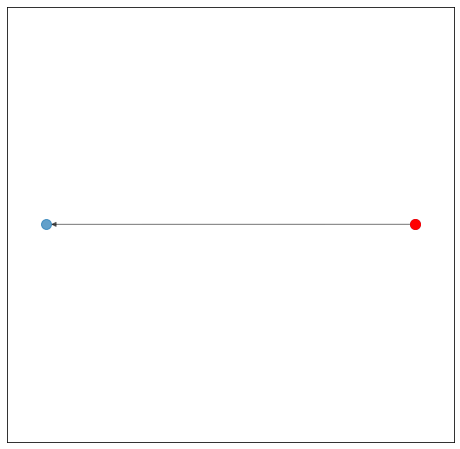

Phishing Gang Num=5


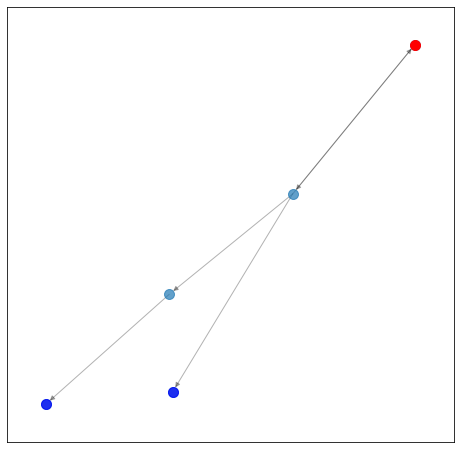

Phishing Gang Num=7


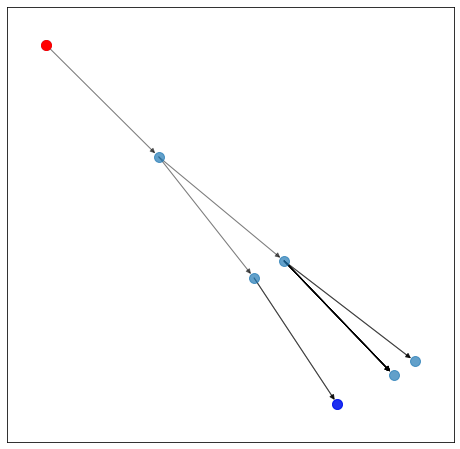

Phishing Gang Num=2


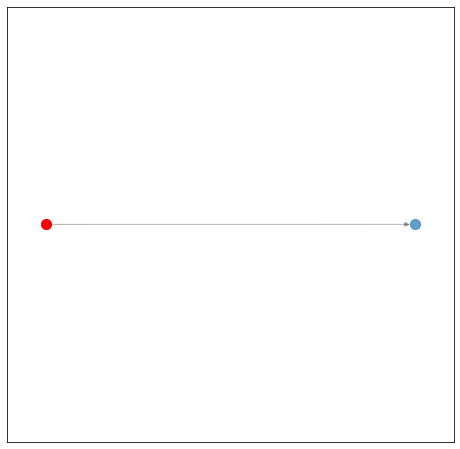

Phishing Gang Num=2


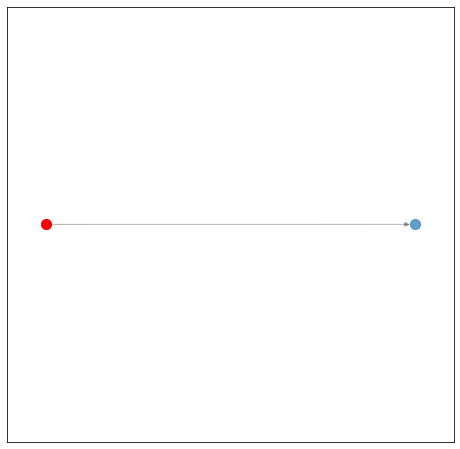

Phishing Gang Num=2


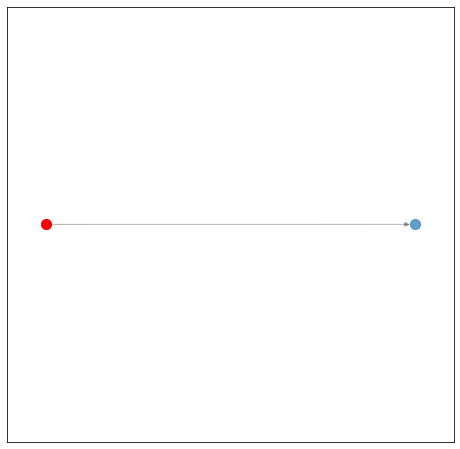

Phishing Gang Num=7


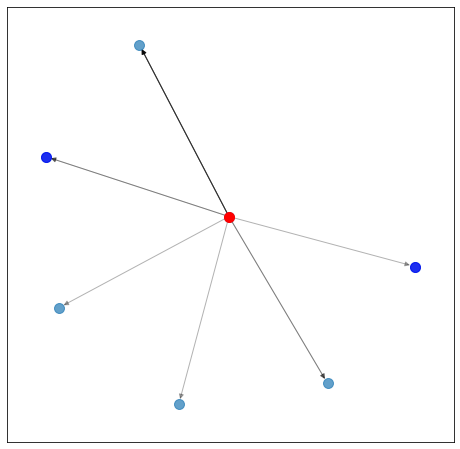

Phishing Gang Num=2


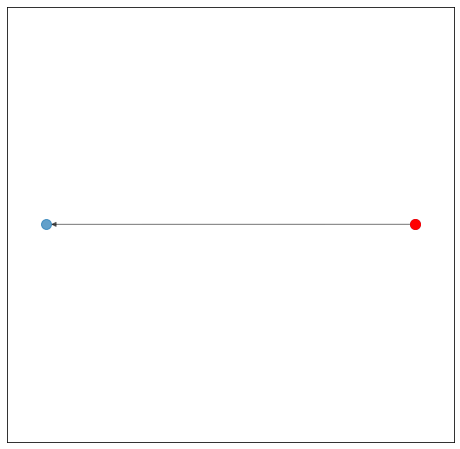

Phishing Gang Num=4


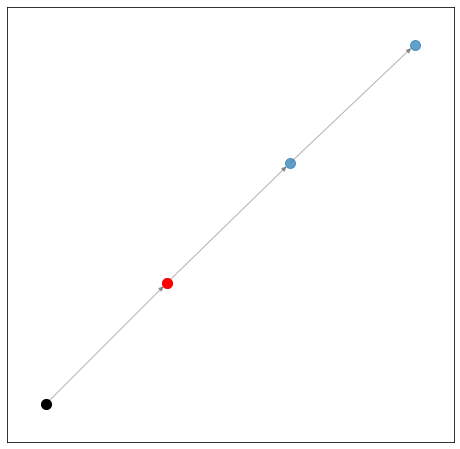

Phishing Gang Num=3


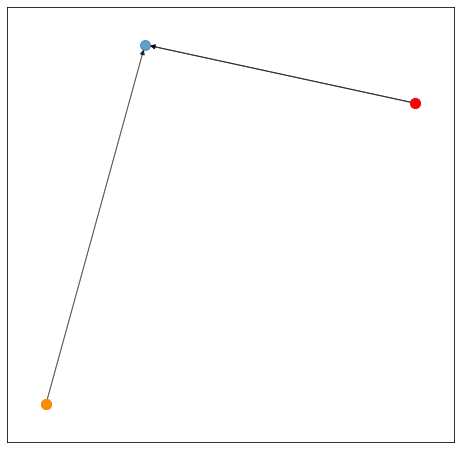

Phishing Gang Num=3


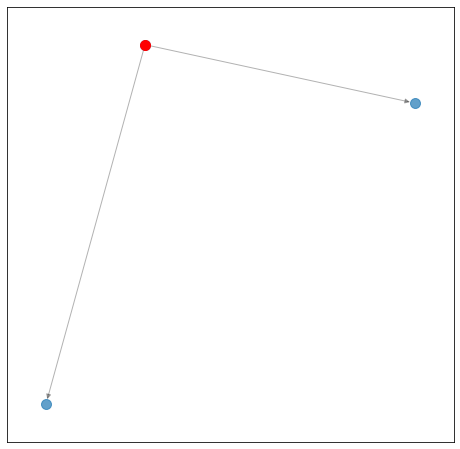

Phishing Gang Num=5


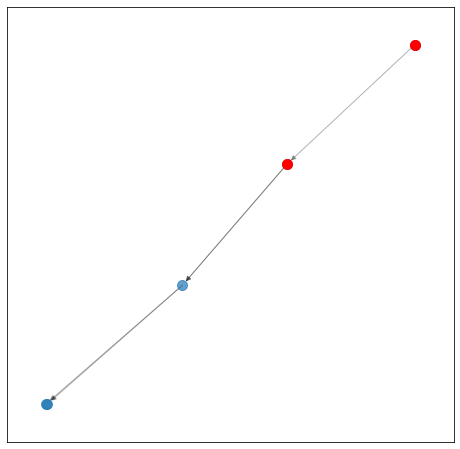

Phishing Gang Num=5


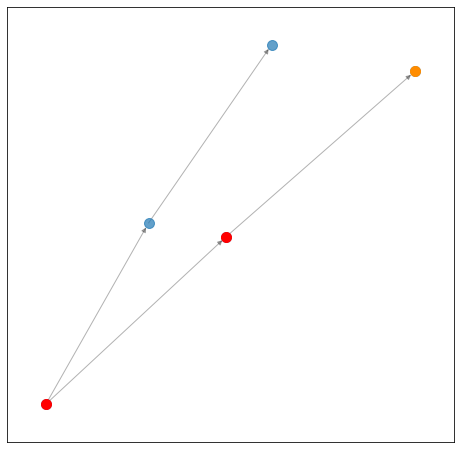

Phishing Gang Num=2


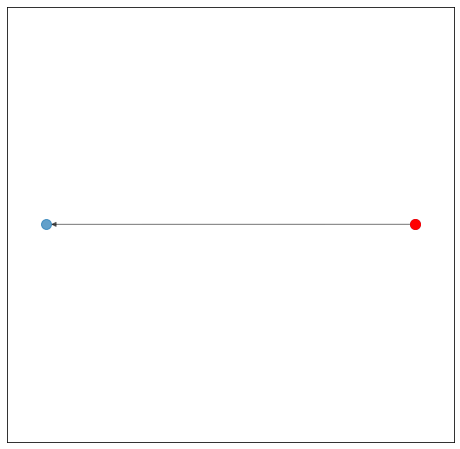

Phishing Gang Num=2


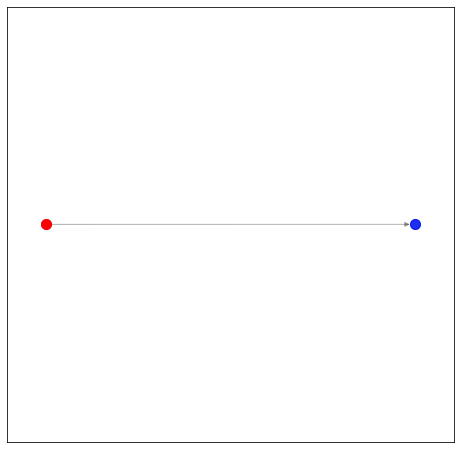

Phishing Gang Num=8


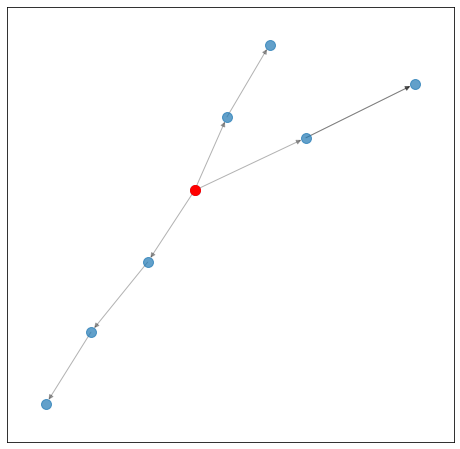

Phishing Gang Num=4


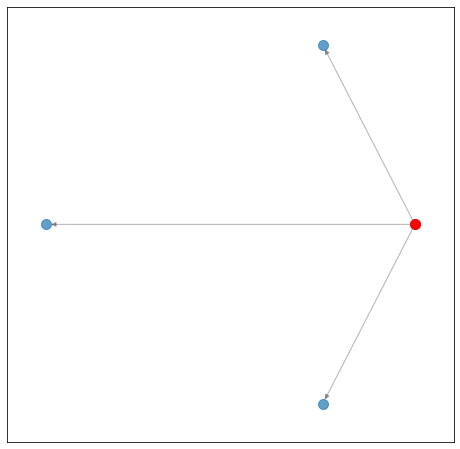

Phishing Gang Num=16


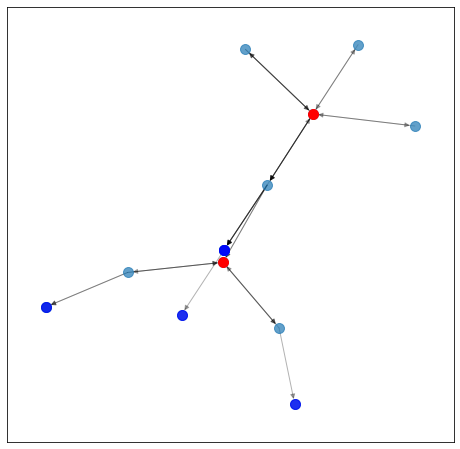

Phishing Gang Num=2


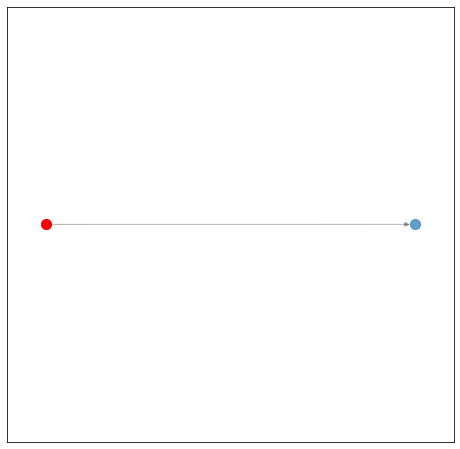

Phishing Gang Num=4


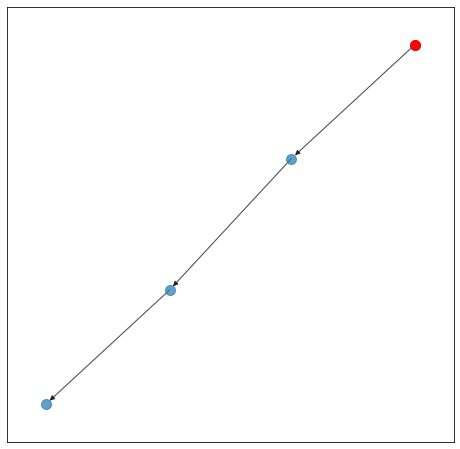

Phishing Gang Num=2


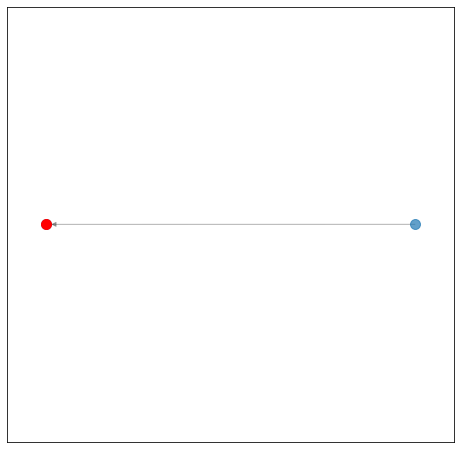

Phishing Gang Num=3


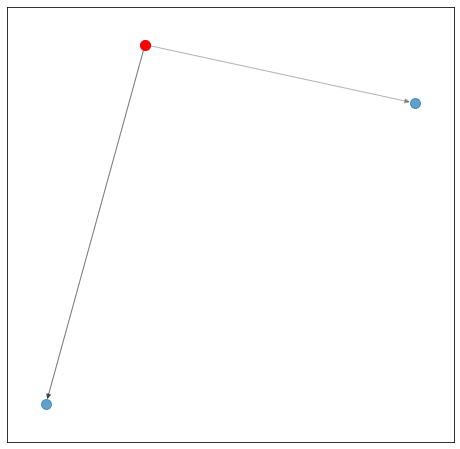

Phishing Gang Num=2


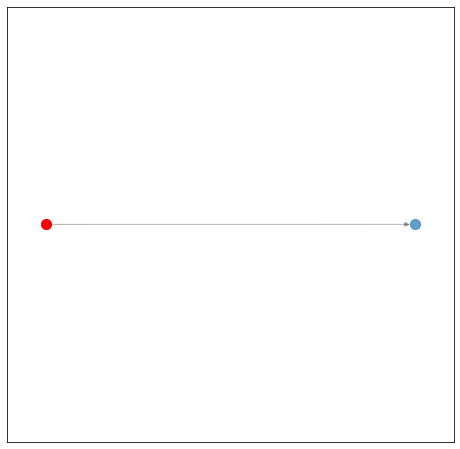

Phishing Gang Num=2


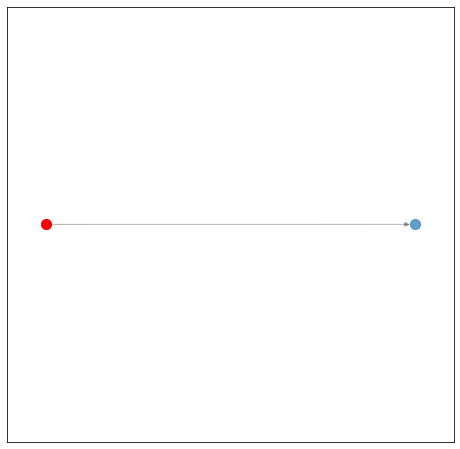

Phishing Gang Num=26


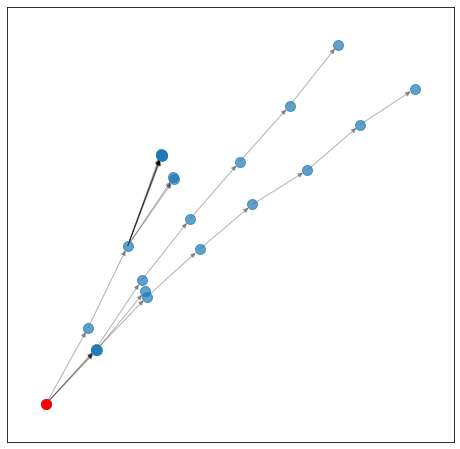

Phishing Gang Num=2


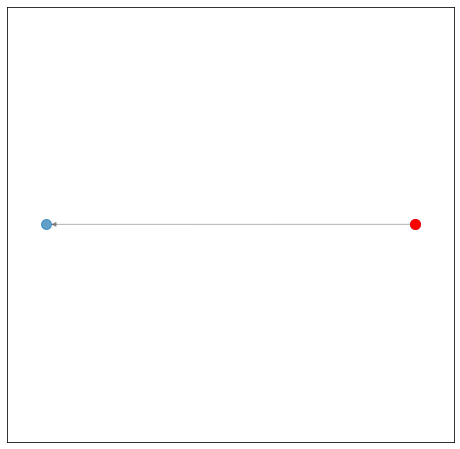

Phishing Gang Num=3


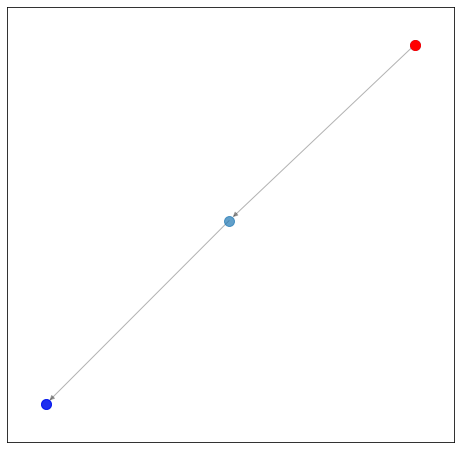

Phishing Gang Num=3


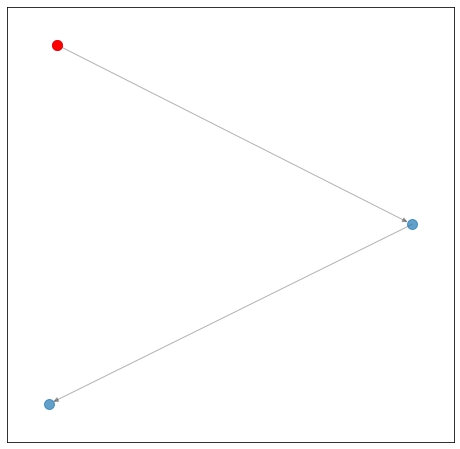

Phishing Gang Num=5


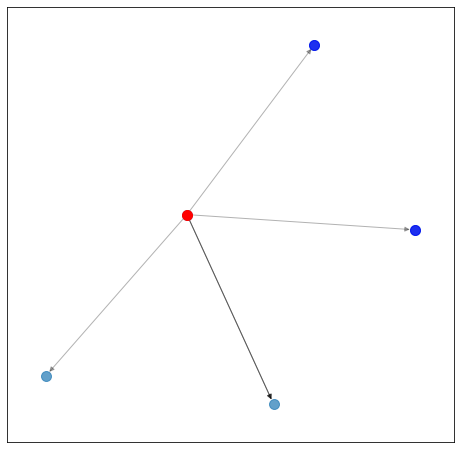

Phishing Gang Num=8


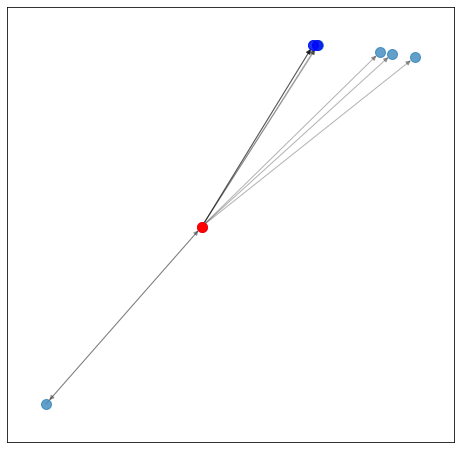

Phishing Gang Num=14


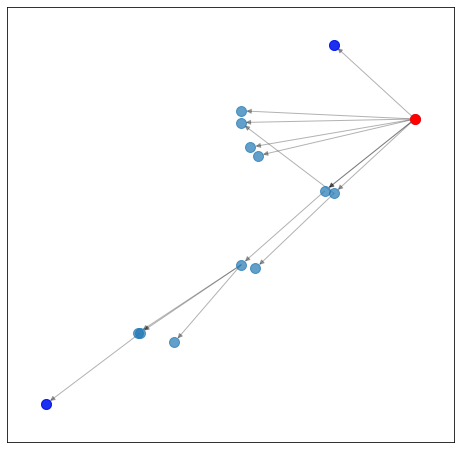

Phishing Gang Num=5


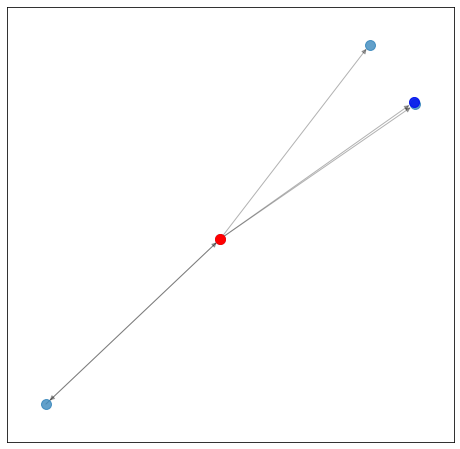

Phishing Gang Num=5


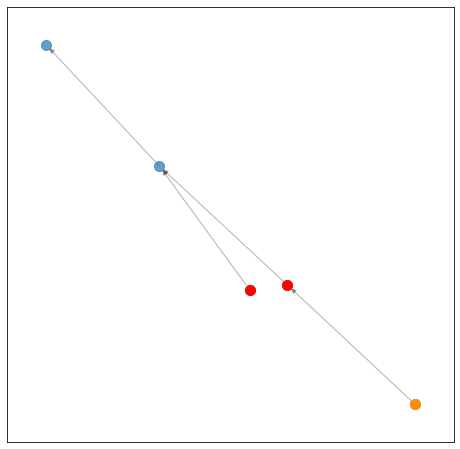

Phishing Gang Num=3


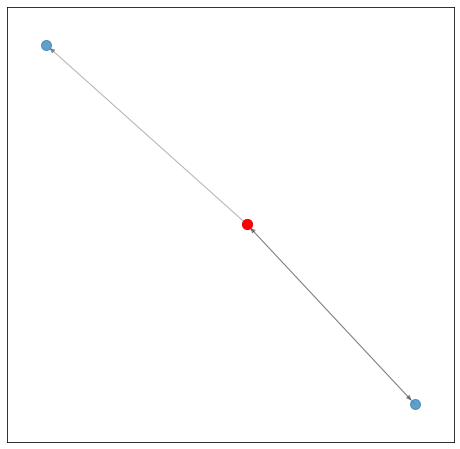

Phishing Gang Num=2


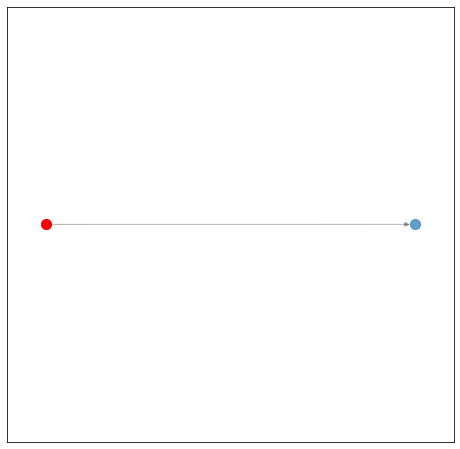

Phishing Gang Num=5


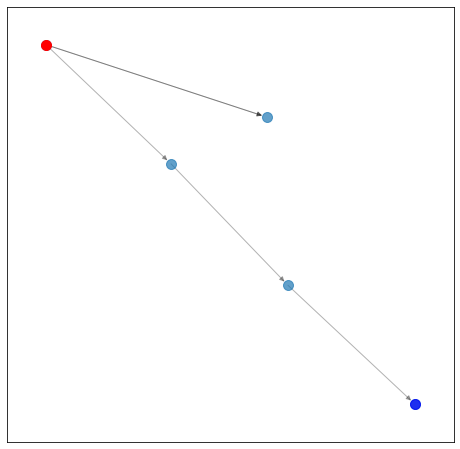

Phishing Gang Num=6


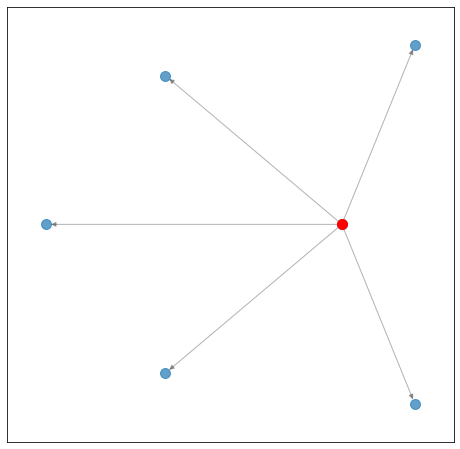

Phishing Gang Num=2


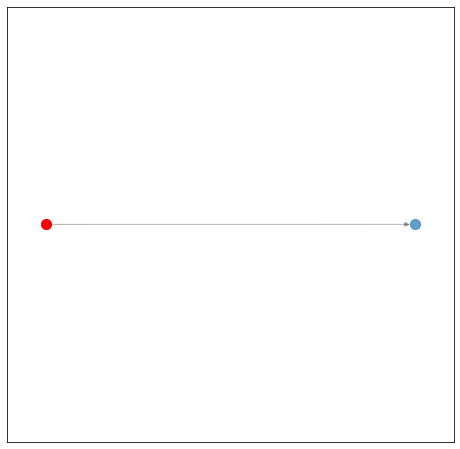

Phishing Gang Num=2


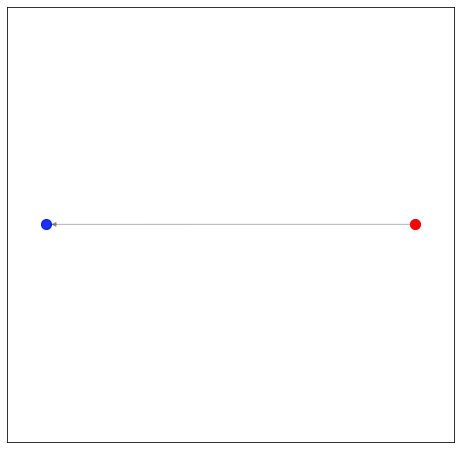

Phishing Gang Num=4


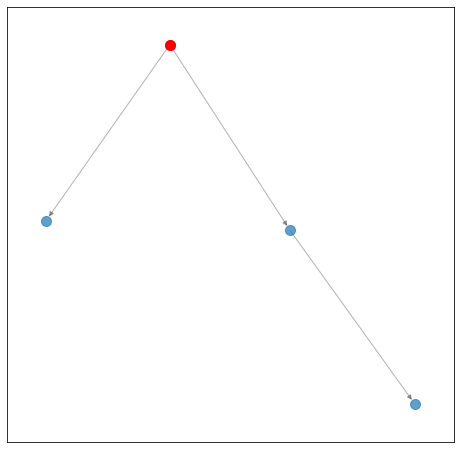

Phishing Gang Num=7


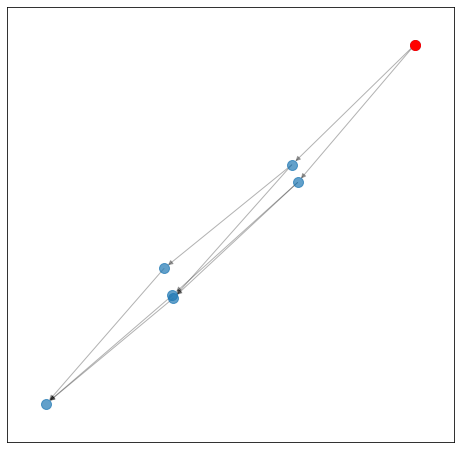

Phishing Gang Num=16


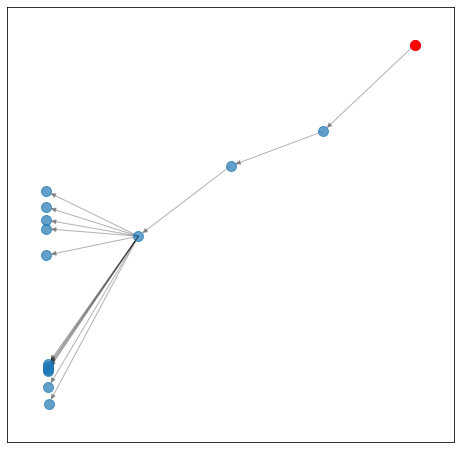

Phishing Gang Num=3


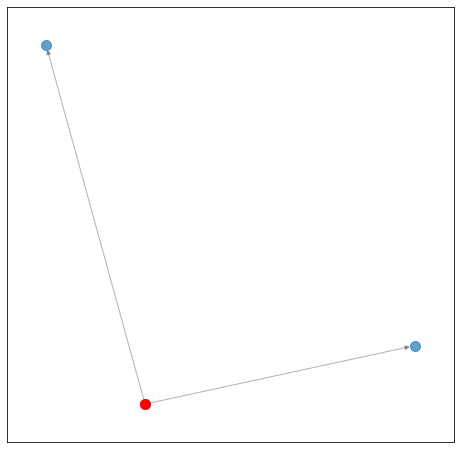

Phishing Gang Num=10


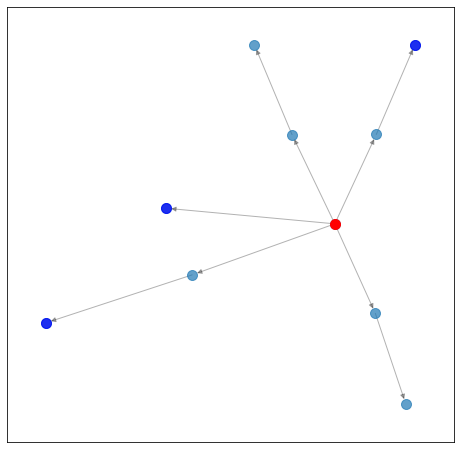

Phishing Gang Num=2


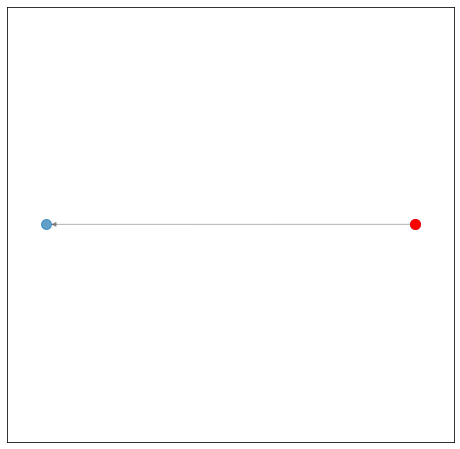

Phishing Gang Num=2


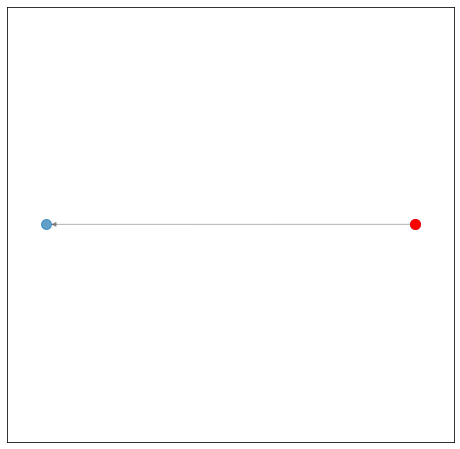

Phishing Gang Num=2


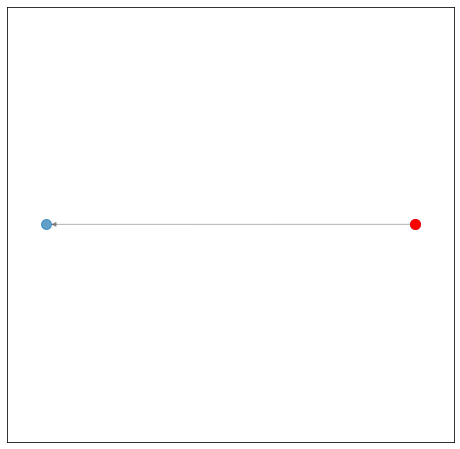

Phishing Gang Num=2


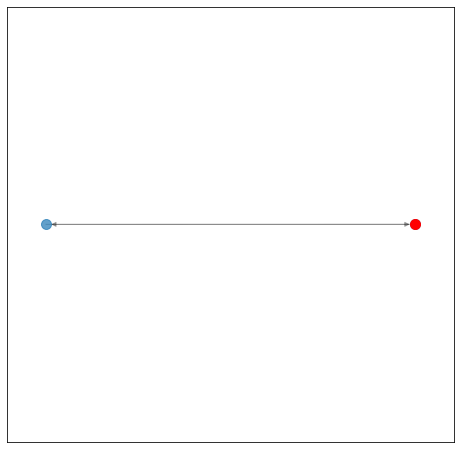

Phishing Gang Num=4


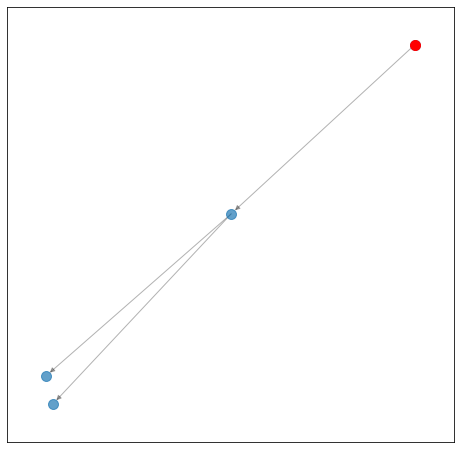

Phishing Gang Num=9


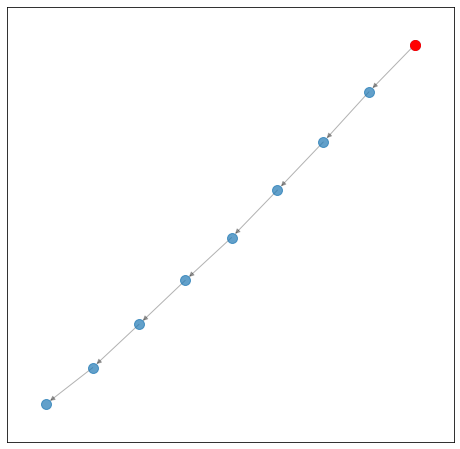

Phishing Gang Num=3


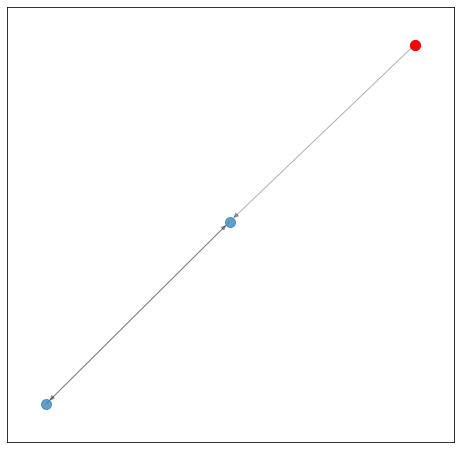

Phishing Gang Num=4


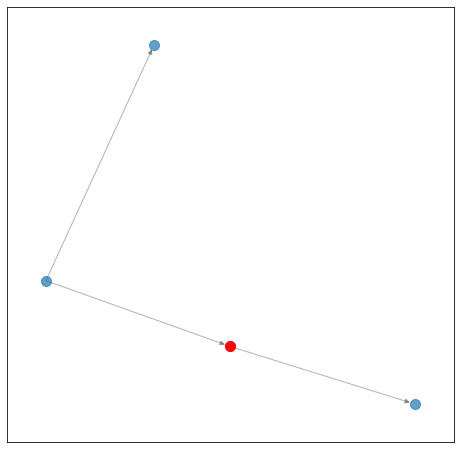

Phishing Gang Num=15


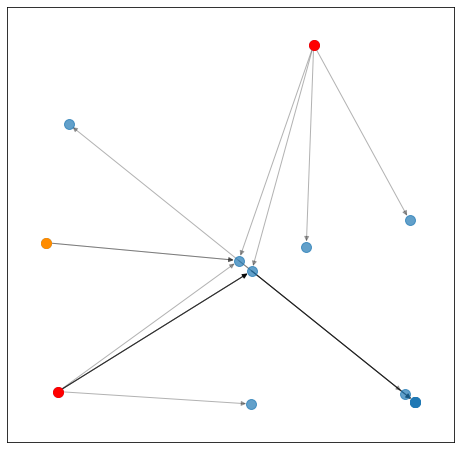

Phishing Gang Num=2


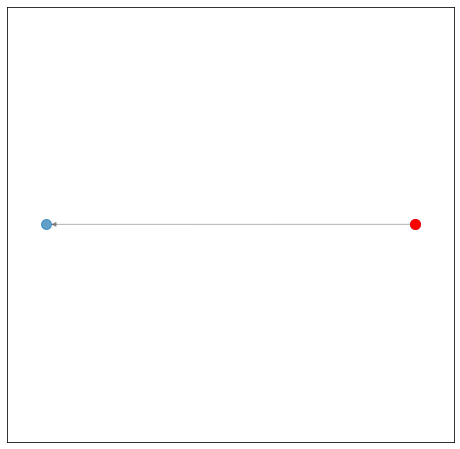

Phishing Gang Num=4


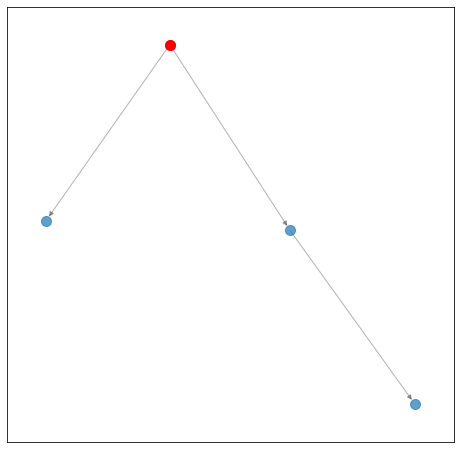

Phishing Gang Num=14


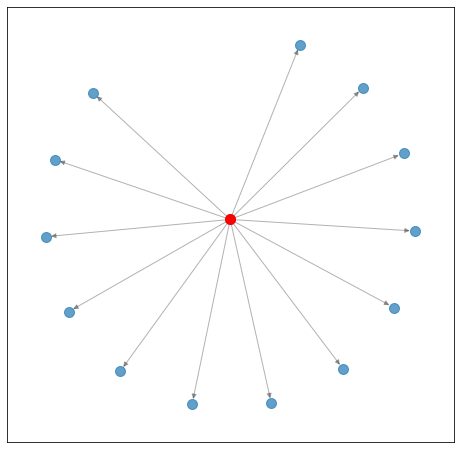

Phishing Gang Num=8


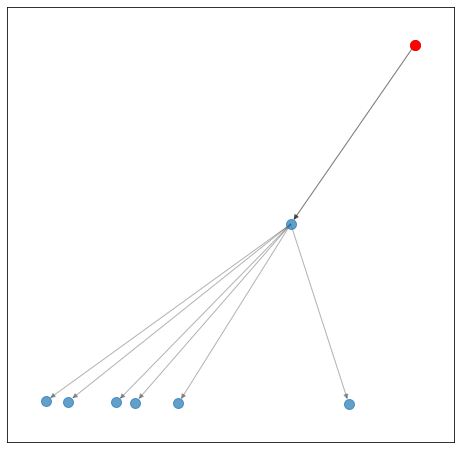

Phishing Gang Num=4


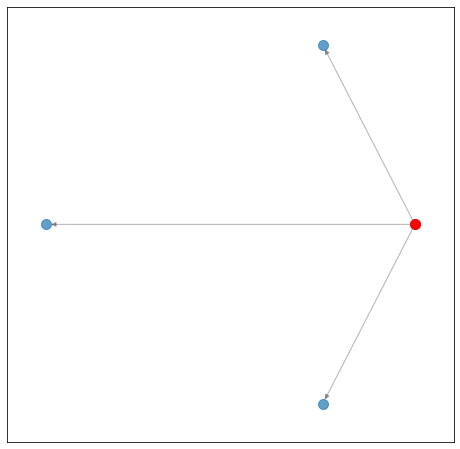

Phishing Gang Num=2


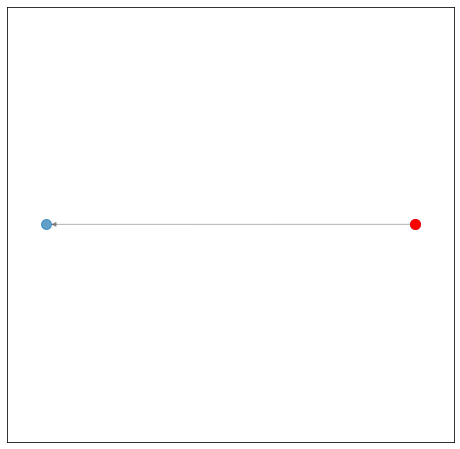

Phishing Gang Num=3


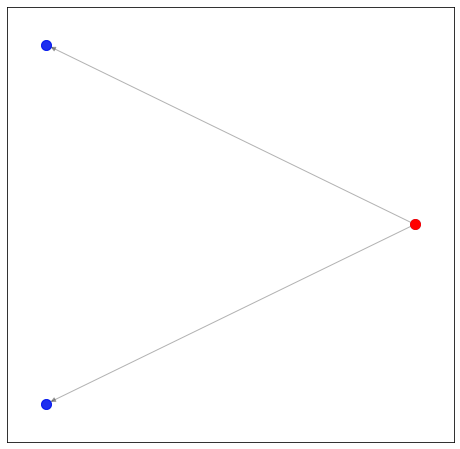

Phishing Gang Num=120


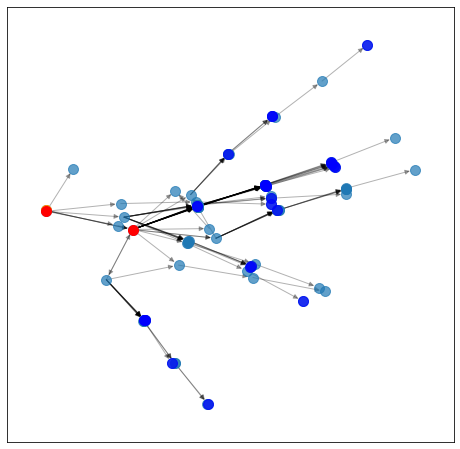

Phishing Gang Num=4


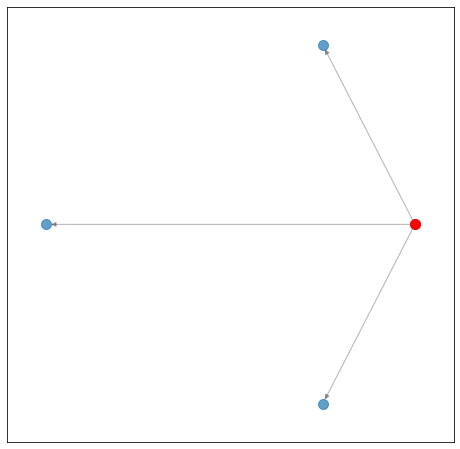

Phishing Gang Num=2


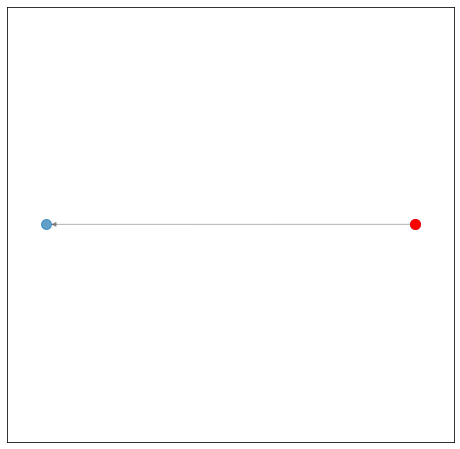

Phishing Gang Num=4


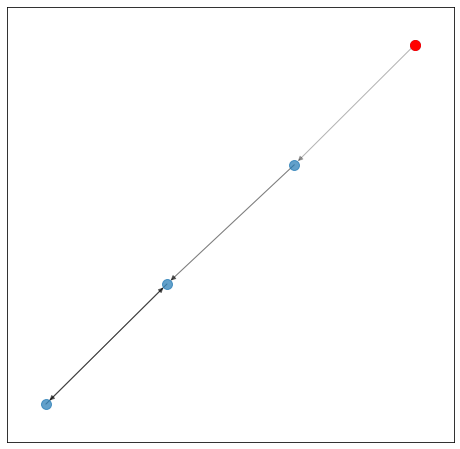

Phishing Gang Num=21


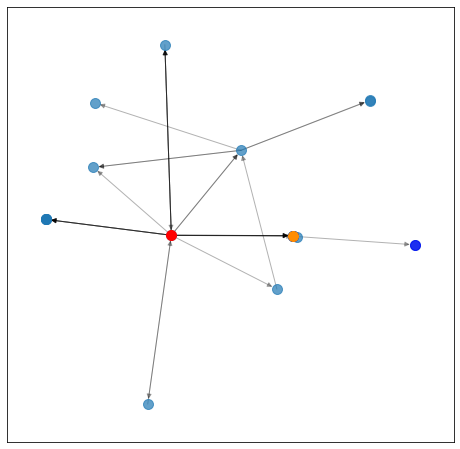

Phishing Gang Num=5


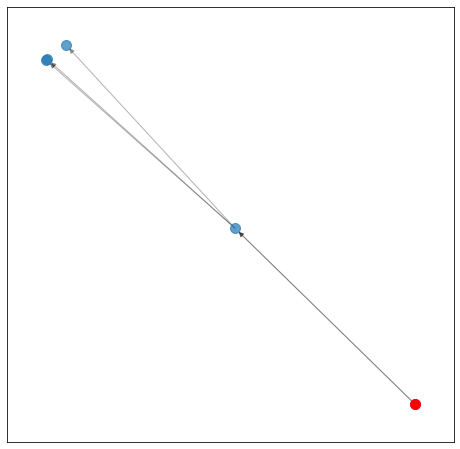

Phishing Gang Num=151


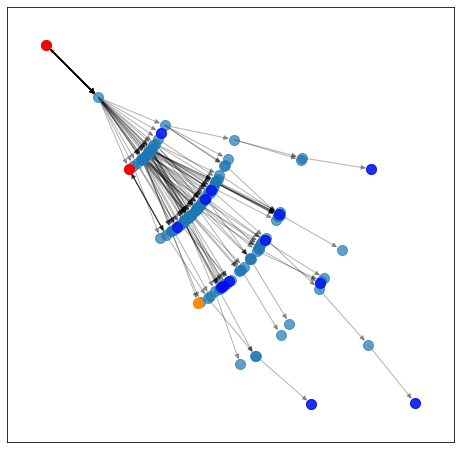

Phishing Gang Num=200


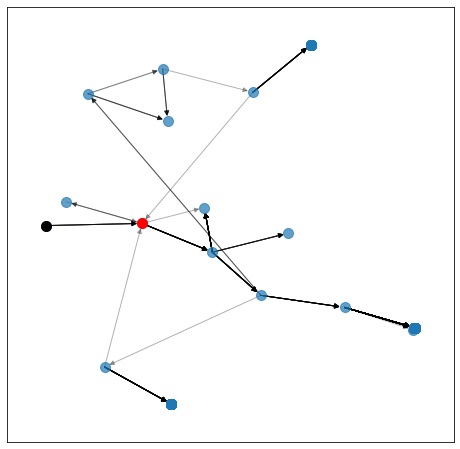

Phishing Gang Num=5


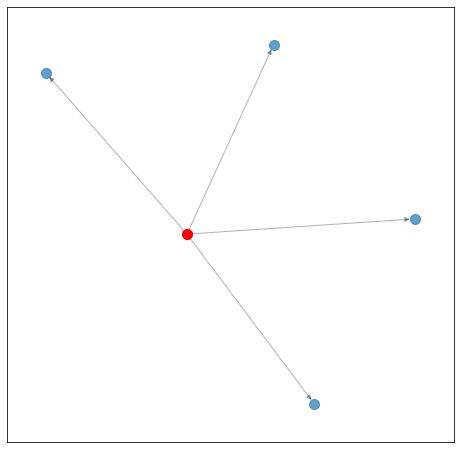

Phishing Gang Num=3


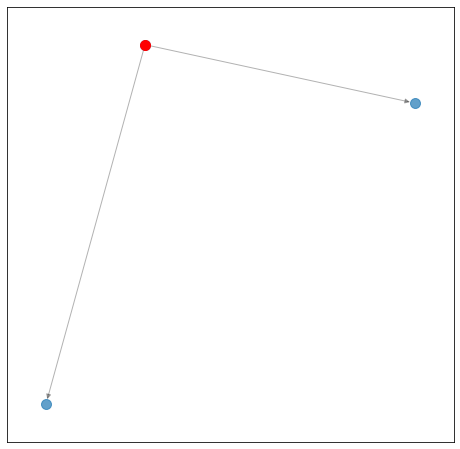

Phishing Gang Num=3


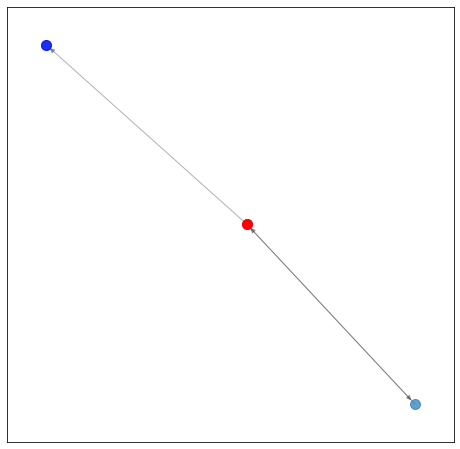

Phishing Gang Num=30


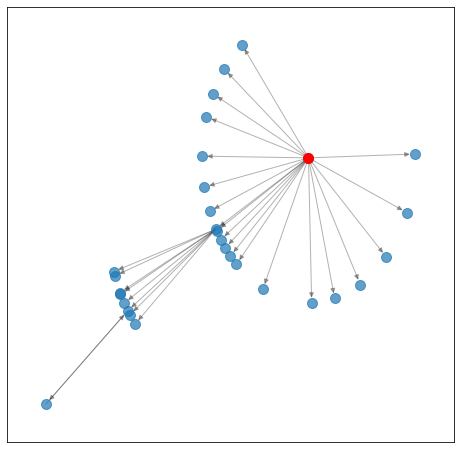

Phishing Gang Num=2


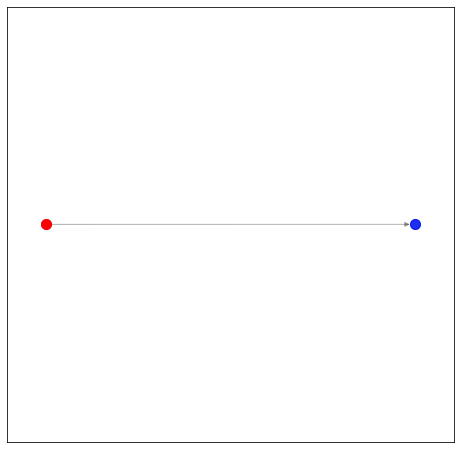

Phishing Gang Num=2


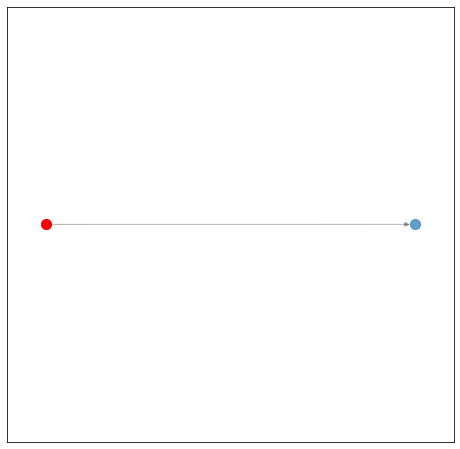

Phishing Gang Num=4


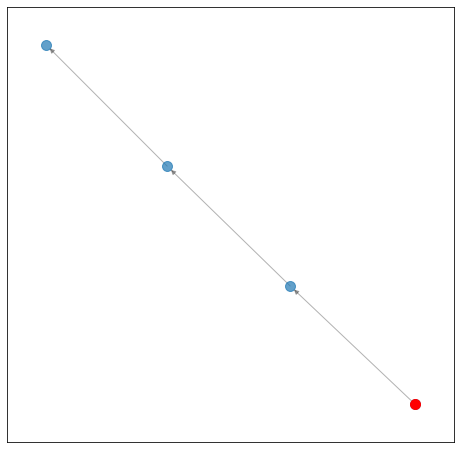

Phishing Gang Num=4


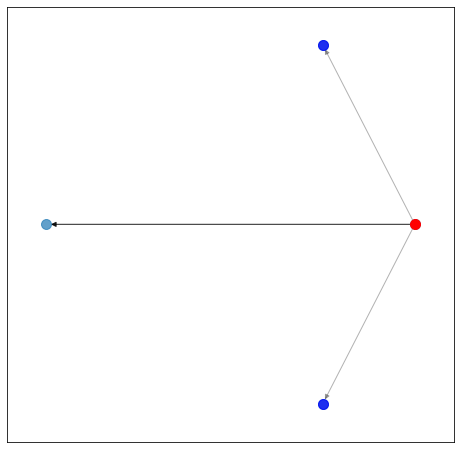

Phishing Gang Num=5


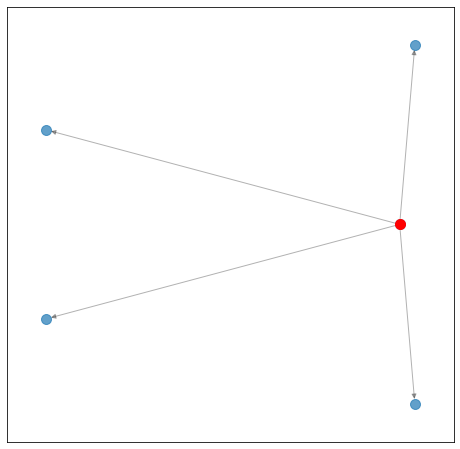

Phishing Gang Num=2


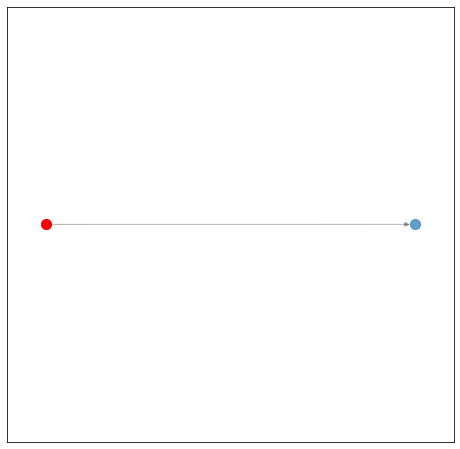

Phishing Gang Num=3


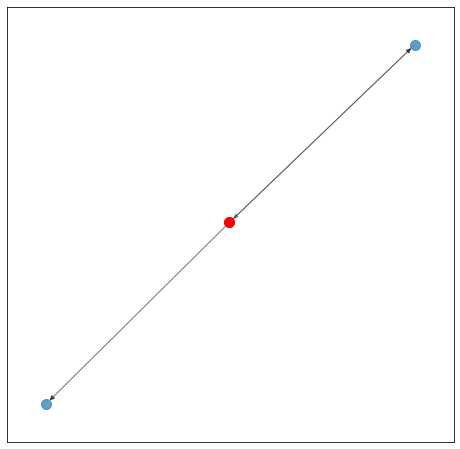

Phishing Gang Num=3


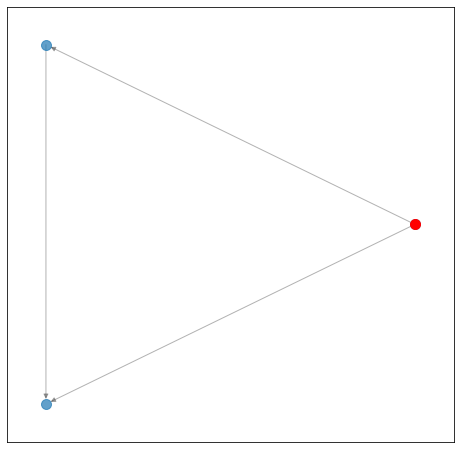

Phishing Gang Num=2


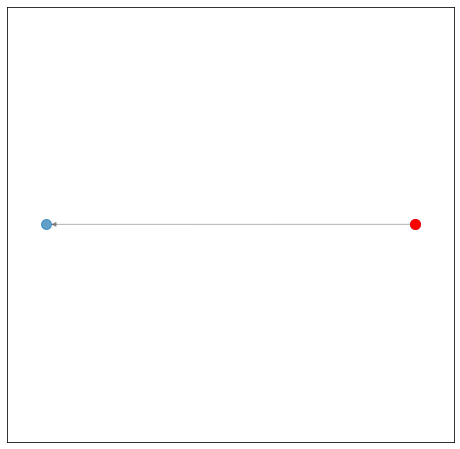

Phishing Gang Num=3


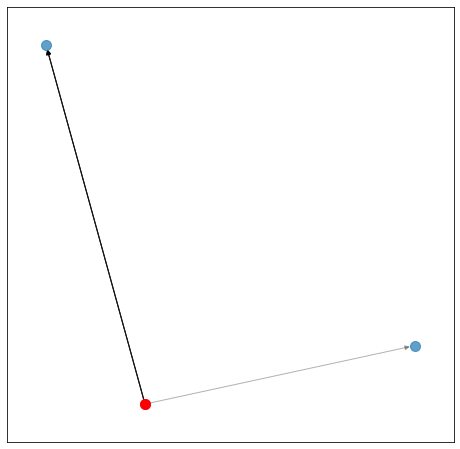

Phishing Gang Num=4


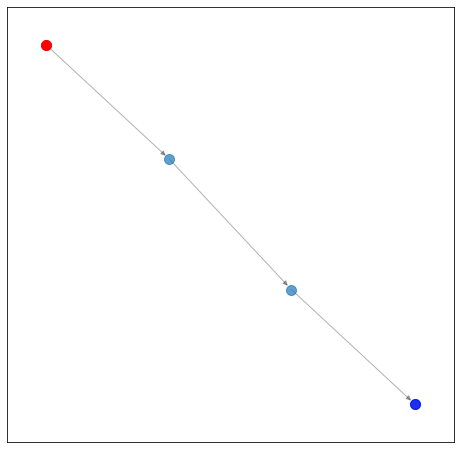

Phishing Gang Num=4


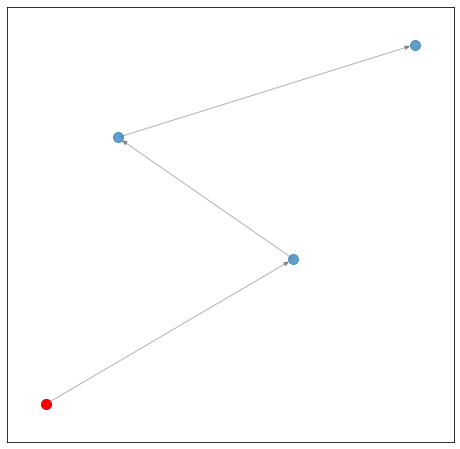

Phishing Gang Num=5


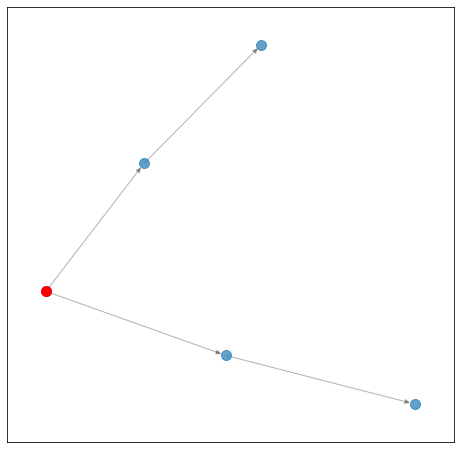

Phishing Gang Num=3


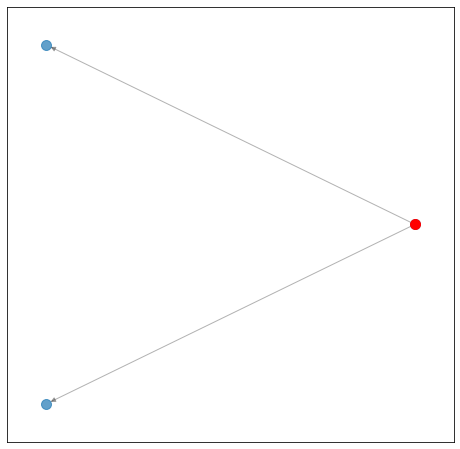

Phishing Gang Num=2


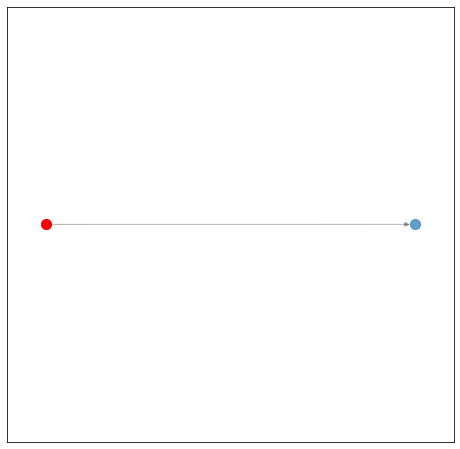

Phishing Gang Num=2


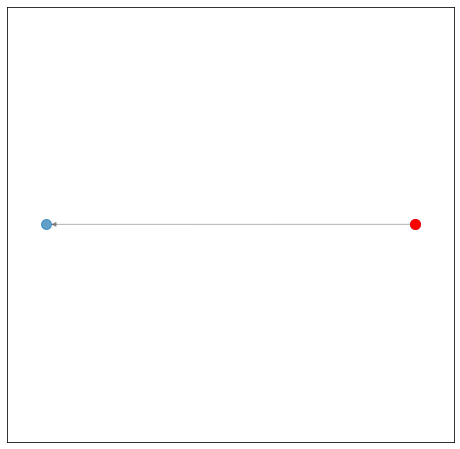

Phishing Gang Num=2


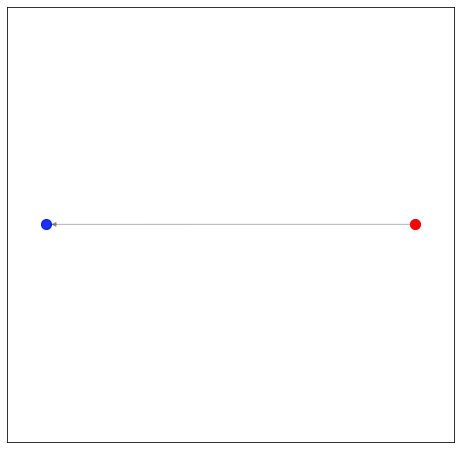

Phishing Gang Num=4


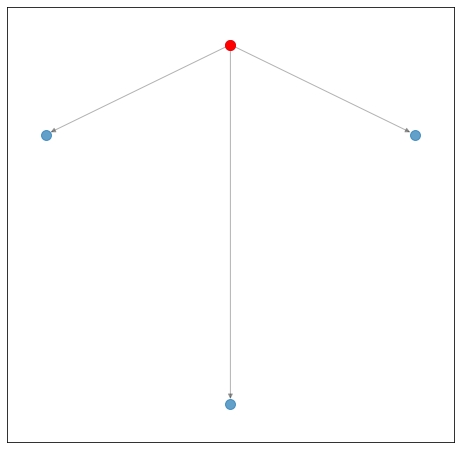

Phishing Gang Num=3


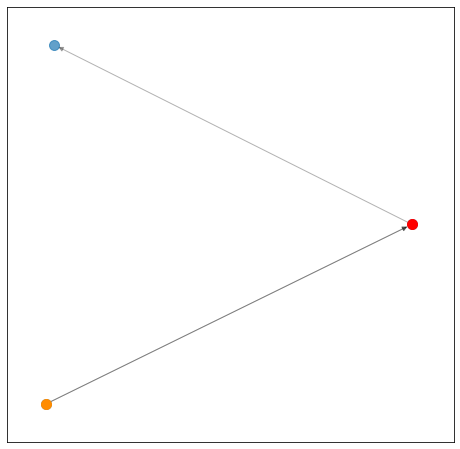

Phishing Gang Num=3


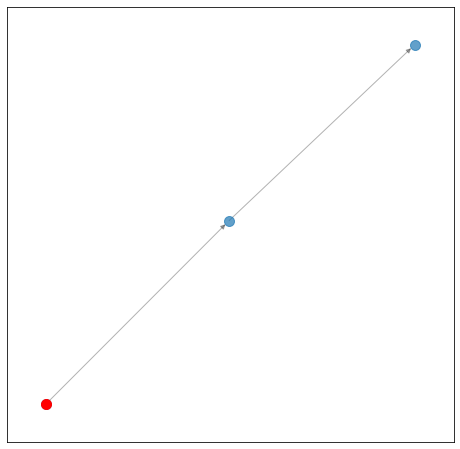

Phishing Gang Num=2


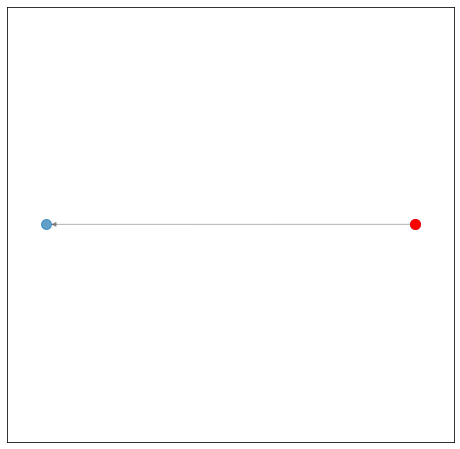

Phishing Gang Num=3


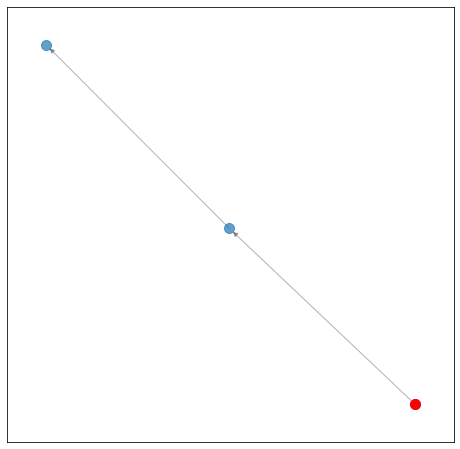

In [49]:
for gang in phishing_gang_sets3:
    if len(gang)>1:
        draw_gang_graph(gang)

In [50]:
phishing_gang_sets3=sorted(phishing_gang_sets3,key=lambda x:len(x))
print([len(gang) for gang in phishing_gang_sets3])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 9, 

In [51]:
print([phishing_gang_sets2.count(gang) for gang in phishing_gang_sets3])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 4, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 4, 6, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 

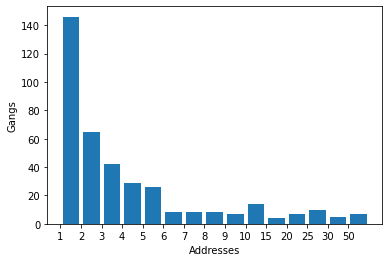

In [52]:
#plot CCDF
bins=list(range(1,10))+[10,15,20,25,30,50,100]
hist,bin_edges = np.histogram([len(gang) for gang in phishing_gang_sets3],bins) # make the histogram
plt.ylabel('Gangs')
plt.xlabel('Addresses')
# # Plot the histogram heights against integers on the x axis
plt.bar(range(len(hist)),hist,width=0.8) 
# # Set the ticks to the middle of the bars
plt.xticks([i-0.5 for i,j in enumerate(hist)],['{}'.format(bins[i]) for i,j in enumerate(hist)])                                            
plt.show()

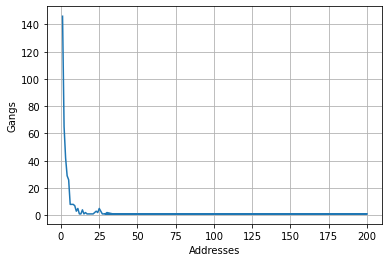

In [53]:
phishing_gang_nums=[len(gang) for gang in phishing_gang_sets3]
plt.plot(list(set(phishing_gang_nums)),[phishing_gang_nums.count(num) for num in set(phishing_gang_nums)])
plt.ylabel('Gangs')
plt.xlabel('Addresses')
plt.grid(True)
plt.show()

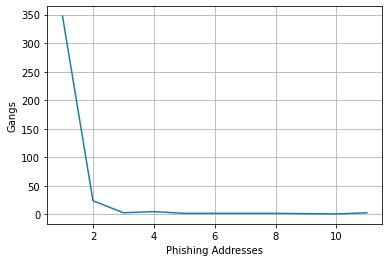

In [54]:
phishing_gang_pnums=[phishing_gang_sets2.count(gang) for gang in phishing_gang_sets3]
plt.plot(list(set(phishing_gang_pnums)),[phishing_gang_pnums.count(pnum) for pnum in set(phishing_gang_pnums)])
plt.ylabel('Gangs')
plt.xlabel('Phishing Addresses')
plt.grid(True)
plt.show()

In [55]:
accum_address=[nd for idx,nd in enumerate(G2.nodes) if G2.nodes[nd]['label']=='A']
accum_address_ingang=[nd for gang in phishing_gang_sets3 for nd in gang if G2.nodes[nd]['label']=='A']
print(len(accum_address),len(accum_address_ingang))

15278 48


In [56]:
print(len(set(accum_address_ingang)))
print([nd for nd in accum_address_ingang if accum_address_ingang.count(nd)>1])

46
['0xa7c7f7d6a5ff40b988103896f3f937073c5359b6', '0x0c47c578323a843256855e78ec739748a275a51a', '0xa7c7f7d6a5ff40b988103896f3f937073c5359b6', '0x0c47c578323a843256855e78ec739748a275a51a']


In [57]:
one_gang=[gang for gang in phishing_gang_sets3 if len(gang)==1]
small_gang=[gang for gang in phishing_gang_sets3 if len(gang)>1 and len(gang)<10]
middle_gang=[gang for gang in phishing_gang_sets3 if len(gang)>=10 and len(gang)<99]
big_gang=[gang for gang in phishing_gang_sets3 if len(gang)>=99]

In [58]:
print(len(one_gang),len(small_gang),len(middle_gang))

146 193 47


In [59]:
low_common_address=[nd for idx,nd in enumerate(G2.nodes) if G2.nodes[nd]['label']=='LC']
high_common_address=[nd for idx,nd in enumerate(G2.nodes) if G2.nodes[nd]['label']=='HC']
print(len(low_common_address),len(high_common_address))

12341814 8585


In [60]:
bridge_address=[nd for idx,nd in enumerate(G2.nodes) if G2.nodes[nd]['label']=='B']
Token_address=[nd for idx,nd in enumerate(G2.nodes) if G2.nodes[nd]['label']=='T']
Exchange_address=[nd for idx,nd in enumerate(G2.nodes) if G2.nodes[nd]['label']=='E']
print(len(bridge_address),len(Token_address),len(Exchange_address))

3584 130 965


In [61]:
def get_laundry_group(gang):
    for idx,nd in enumerate(G2.nodes):
        G2.nodes[nd]['visited']=False
    laundry_group=set()
    mates=gang.copy()
    while len(mates)!=0:
        a=mates.pop()
        G2.nodes[a]['visited']=True
        end_set=set()
        for nd in G2.succ[a]:
            if not G2.nodes[nd]['visited']:
                if G2.nodes[nd]['label'] in ['E','T','HC','LC','A']:
                    end_set.add(nd)
                    G2.nodes[nd]['visited']=True                
                else:
                    mates.add(nd)
        laundry_group.add(a)
        laundry_group=laundry_group|end_set
#         print(end_set)
    return laundry_group.copy()

In [62]:
laundry_groups=[]
for gang in phishing_gang_sets3:
    laundry_group=get_laundry_group(gang)
    laundry_groups.append(laundry_group)
    print('('+str(len(gang))+','+str(len(laundry_group))+')',end=' ')

(1,1) (1,2) (1,2) (1,3) (1,1) (1,2) (1,2) (1,2) (1,3) (1,1) (1,1) (1,2) (1,2) (1,2) (1,1) (1,2) (1,1) (1,2) (1,2) (1,1) (1,2) (1,4) (1,2) (1,2) (1,1) (1,1) (1,1) (1,1) (1,2) (1,2) (1,2) (1,1) (1,2) (1,2) (1,2) (1,1) (1,1) (1,1) (1,1) (1,2) (1,2) (1,2) (1,1) (1,1) (1,1) (1,2) (1,2) (1,2) (1,2) (1,1) (1,1) (1,6) (1,2) (1,1) (1,1) (1,3) (1,3) (1,2) (1,2) (1,1) (1,1) (1,1) (1,17) (1,1) (1,2) (1,1) (1,2) (1,2) (1,3) (1,2) (1,2) (1,2) (1,2) (1,3) (1,2) (1,1) (1,3) (1,3) (1,2) (1,1) (1,2) (1,2) (1,2) (1,1) (1,1) (1,2) (1,1) (1,2) (1,2) (1,2) (1,2) (1,2) (1,2) (1,1) (1,1) (1,1) (1,2) (1,2) (1,1) (1,1) (1,1) (1,1) (1,2) (1,1) (1,2) (1,1) (1,1) (1,1) (1,2) (1,3) (1,4) (1,2) (1,1) (1,1) (1,3) (1,3) (1,2) (1,2) (1,1) (1,1) (1,2) (1,2) (1,2) (1,1) (1,3) (1,2) (1,2) (1,3) (1,1) (1,2) (1,2) (1,2) (1,1) (1,2) (1,4) (1,1) (1,2) (1,1) (1,2) (1,2) (1,1) (1,2) (1,1) (1,4) (1,2) (1,3) (2,2) (2,6) (2,2) (2,4) (2,2) (2,11) (2,3) (2,5) (2,2) (2,3) (2,3) (2,5) (2,3) (2,5) (2,5) (2,3) (2,4) (2,3) (2,3) (2,3) (2

In [63]:
import random
def set_pos(phishing_gang,laundry_group):
    pos=dict()
    #label proflie
    phishs=set([nd for nd in laundry_group if G2.nodes[nd]['label']=='P'])
    accums_g=set([nd for nd in phishing_gang if G2.nodes[nd]['label']=='A'])
    first_layer_nodes=phishs|accums_g
    second_layer_nodes=set([nd for nd in laundry_group if G2.nodes[nd]['label'] in ['B','H']])
    third_layer_nodes=laundry_group-first_layer_nodes-second_layer_nodes
    #set pos
    first_layer_pos=[(x,y) for x in range(5,150,5) for y in range(95,120,5)]
    for nd in first_layer_nodes:
        cord=random.choice(first_layer_pos)
        first_layer_pos.remove(cord)
        pos[nd]=cord
    second_layer_pos1=[(x,y) for x in range(5,120,5) for y in range(35,90,5)]
    second_layer_pos2=[(x,y) for x in range(125,150,5) for y in range(35,90,5)]    
    for nd in second_layer_nodes:
        if G2.nodes[nd]['is_inact']==1:
            cord=random.choice(second_layer_pos2)
            second_layer_pos2.remove(cord)
        else:
            cord=random.choice(second_layer_pos1)
            second_layer_pos1.remove(cord)
        pos[nd]=cord
    third_layer_pos1=[(x,y) for x in range(5,120,5) for y in range(5,30,5)]
    third_layer_pos2=[(x,y) for x in range(125,150,5) for y in range(5,30,5)]
    for nd in third_layer_nodes:
        if G2.nodes[nd]['label'] in ('E','T'):
            cord=random.choice(third_layer_pos2)
            third_layer_pos2.remove(cord)
        else:
            cord=random.choice(third_layer_pos1)
            third_layer_pos1.remove(cord)
        pos[nd]=cord
    return pos.copy()

def draw_laundry_graph(phishing_gang,laundry_group):
    sub_graph=nx.MultiDiGraph()
    sub_graph=nx.union(sub_graph,G2.subgraph(laundry_group))
    print('Phishing Gang',"Num="+str(len(phishing_gang)))
    nodes_label={key:[] for key in ['E','T','HC','LC','A','B','P','H']}
    for nd in laundry_group:
        nodes_label[sub_graph.nodes[nd]['label']].append(nd)
    in_actives=[nd for nd in laundry_group if sub_graph.nodes[nd]['is_inact']==1]
    plt.figure(figsize=(5,4))
    pos=set_pos(phishing_gang,laundry_group)
    nx.draw_networkx_nodes(sub_graph,pos,node_size=100)
    nx.draw_networkx_edges(sub_graph,pos,node_size=100,alpha=0.3)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=in_actives,node_color='blue',node_size=100)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=nodes_label['HC'],node_color='darkgray',node_size=100)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=nodes_label['LC'],node_color='gray',node_size=100)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=nodes_label['T'],node_color='darkgreen',node_size=100)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=nodes_label['E'],node_color='green',node_size=100)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=nodes_label['A'],node_color='darkorange',node_size=100)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=nodes_label['P'],node_color='red',node_size=100)
    nx.draw_networkx_nodes(sub_graph,pos,nodelist=nodes_label['H'],node_color='black',node_size=100)
    plt.xlim(0,150)
    plt.ylim(0,120)
    plt.show()

Phishing Gang Num=72


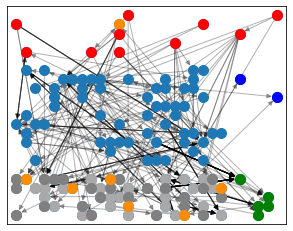

In [64]:
draw_laundry_graph(phishing_gang_sets3[-5],laundry_groups[-5])

### Load Result

In [65]:
gang_patterns=list()
for gang in phishing_gang_sets3:
    graph=nx.MultiDiGraph()
    graph=nx.union(graph,G2.subgraph(gang))
    gang_patterns.append(graph)
laundry_patterns=list()
for group in laundry_groups:
    graph=nx.MultiDiGraph()
    graph=nx.union(graph,G2.subgraph(group))
    laundry_patterns.append(graph)

In [66]:
#var=['tainted_scores1', 'tainted_scores2', 'phishing_gang_sets', 'laundry_group_sets','suspect_nodes', 'gang_patterns','laundry_patterns']
result_data=dict()
result_data['tainted_scores1']=in_tainted_values1
result_data['tainted_scores2']=in_tainted_values
result_data['phishing_gang_sets']=phishing_gang_sets3
result_data['laundry_group_sets']=laundry_groups
result_data['suspect_nodes']=accum_address

In [67]:
result_data['gang_patterns']=gang_patterns
result_data['laundry_patterns']=laundry_patterns

In [68]:
def write_pickle(data,fname):
    with open(fname, 'wb') as f:
        pickle.dump(data,f)
write_pickle(result_data,'result/subgraph5-result.pkl')